## Libraries

In [1]:
import geopandas as gpd
import shapely
from shapely.geometry import box, LineString, Point,MultiPoint
from shapely.ops import nearest_points
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import networkx as nx
import re
import osmnx as ox
import itertools
#from geopy import distance
from shapely import wkt
from math import radians, degrees, sin, cos, asin, acos, sqrt, floor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.mode.chained_assignment = None

/Applications/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
string = 'bs1'
re.sub('\D', '', string)


'1'

## Parameters

In [151]:
walk_speed = 1.4 # m/s
#park_pphour = 2.50   # $; can be tuned       actually, going to the use the parking rate published with data
drive_speed = 5  # mph, speed as you go to park
num_park_hours = 4   # can be tuned
walk_speed = 1.3  # m/s
scoot_speed = 2.5  # m/s
scoot_ppmin = 0.39  # $/min
scoot_fix_price = 1  # $
bike_speed = 15 * 1000 / 3600  # m/s
bs_price = 20/300  # $/min
PT_price = 2.75  # $/ride
TNC_wait_time = 7 # min
TNC_fix_price = 2.55 + 3  # $  fixed cost + tax/fee (estimate tax+fee = 3, for simplicity)
TNC_op_ppmile = 1.75  # $/mile
TNC_op_ppmin =  1  #0.35  # $/min
pb_price = 0  # $
pv_ppmile = 0.20  # $/mile
zip_ppmin = 11/60   # $/min; still need to incorporate fixed monthly cost
zip_fixed_pmonth = 9
est_num_ziptrips = 4

# conversion factors
meters_in_mile = 1609
miles_in_km = 0.621371

# time-dependency: Consider a period of length 120 minutes (i.e. 7-9am), where each interval is 10 mintues long
interval_spacing = 10 # minutes
len_period = 120  # minutes
num_intervals = int(120/interval_spacing)+1

# beta parameters
b_price, b_TT = 1, 10/60  #21.59/60    # b_risk should be tuned
b_risk = b_TT
# for median hourly wage estimate for PA: https://www.bls.gov/oes/current/oes_pa.htm
b_disc = b_TT  # b/c defined w.r.t. travel time
b_rel = 0.5 * b_TT  # b/c defined w.r.t. travel time

# First, for every edge in the G_bs network, add a "discomfort" cost associated with biking
# For simplicity, call it [some_scalar] * avg TT. So we will think of it in terms of TT minutes
# Move this scalar to the top of the code in the params 
discomf_weight_bike = 3/10  # TO BE TUNED!
discomf_weight_sw = 1/10
reliability_weight_active_mode = 1
reliability_weight_nonactive_mode = 1.5

active_modes = ['w','pb','bs','sc']
nonactive_mode = ['pv','pt','t','z']  
board_alight = ['board', 'alight']  # these are special case edges
reliability_weight_active_mode = 1
reliability_weight_nonactive_mode = 1.5

# rel_weights = dict(zip(active_modes, [reliability_weight_active_mode]*len(active_modes)))
# rel_weights.update(dict(zip(nonactive_mode, [reliability_weight_nonactive_mode]*len(nonactive_mode))))
# rel_weights

active_modes = ['w','pb','bs','sc']
nonactive_mode = ['pv','pt','t','z']  # where to put board and alight? i think they are special cases

In [6]:
def rel_weights(mode):
    active_modes = ['w','pb','bs','sc']
    nonactive_modes = ['pv','pt','t','z']
    if mode in nonactive_modes:
        rel_weight = 1.5  #np.random.uniform(1.1, 1.6)
    if mode in active_modes:
        rel_weight = 1
    return rel_weight

In [7]:
rel_weights('z')

1.5

## Helper functions

In [8]:
# nodes_type_list is list of tuples of form [(nodes_df, node_color, node_label)]
# def plot_nodes_and_edges(node_type_list, edges_df):
#     fig, ax = plt.subplots(figsize=(10,10))
#     ax.set_aspect('equal')
#     edges_df.plot(ax=ax, color = 'darkgray', zorder=1, label='edges')
#     for n in node_type_list:
#         n[0].plot(ax=ax, color = n[1], label = n[2], zorder=2)
#     ax.legend()
#     return ax

In [9]:
def rename_nodes(G, prefix):
    re.sub('\D', '', string)
    new_nodename = [prefix + re.sub('\D', '', str(i)) for i in G.nodes]
    namemap = dict(zip(G.nodes, new_nodename))
    G = nx.relabel_nodes(G, namemap, True)
    return G

see: https://autogis-site.readthedocs.io/en/latest/notebooks/L3/06_nearest-neighbor-faster.html
for a faster implementation 

In [10]:
def draw_graph(G, node_color, node_cmap, edge_color):
    # draw the graph in networkx
    node_coords = nx.get_node_attributes(G, 'pos')    
    fig, ax = plt.subplots(figsize=(20,20))
    nx.draw(G, pos=node_coords, with_labels=False, font_color='white',  font_weight = 'bold',
            node_size=20, node_color=node_color, edge_color=edge_color, arrowsize=10, ax=ax)
    # add legend for node color    
    inv_node_cmap = dict(zip(node_cmap.values(), node_cmap.keys()))
    for v in set(inv_node_cmap.keys()):
        ax.scatter([],[], c=v, label=inv_node_cmap[v])
    ax.legend(loc = 'upper right')
    return ax

In [11]:
# returns the travel mode the corresponds to the node
def mode(node_name):
    mode_of_node = re.sub(r'[^a-zA-Z]', '', node_name)
    return mode_of_node
mode('bs1')

'bs'

In [12]:
def get_coord_matrix(G):
    coords_dict = nx.get_node_attributes(G, 'pos')
    nid_map = dict(zip(range(len(coords_dict.keys())), list(coords_dict.keys())))
    coord_matrix = np.array(list(coords_dict.values()))
    return (nid_map, coord_matrix)

In [13]:
# find the great circle distance between an input row (point) and a reference matrix (all other points)
# GCD: https://medium.com/@petehouston/calculate-distance-of-two-locations-on-earth-using-python-1501b1944d97#:~:text=The%20Great%20Circle%20distance%20formula,that%20the%20Earth%20is%20spherical.
# inputs: row (coords of single point), matrix_ref (coordinate matrix for all points)

# code source: https://github.com/gboeing/osmnx/blob/main/osmnx/distance.py
def calc_great_circle_dist(row, matrix_ref, earth_radius=6371009):
    y1 = np.deg2rad(row[1])  # y is latitude 
    y2 = np.deg2rad(matrix_ref[:,1])
    dy = y2 - y1

    x1 = np.deg2rad(row[0])
    x2 = np.deg2rad(matrix_ref[:,0])
    dx = x2 - x1

    h = np.sin(dy / 2) ** 2 + np.cos(y1) * np.cos(y2) * np.sin(dx / 2) ** 2
    h = np.minimum(1, h)  # protect against floating point errors
    arc = 2 * np.arcsin(np.sqrt(h))

    # return distance in units of earth_radius
    return arc * earth_radius

In [14]:
def sp_string(sp_edges):
    s = ''
    for i, e in enumerate(sp_edges):
        s = s + ' ' + e[0]
        
        if i == len(sp_edges) - 1:  
            s = s + ' ' + e[1]
#             s = s + ' ' + 'dst'   # RE-ADD THIS WHEN WE INCLUDE OD CONNECTORS
    return(s)

In [15]:
# find total cost of shortest weighted path
# input: graph, edges of shortest path, attribute used as weight
# output: total cost of shortest path
def sp_total_cost(G, sp_edges, weight):
    total_cost = 0
    edge_costs = []
    for e in sp_edges:
        edge_costs.append(G.edges[e][weight])
        total_cost += G.edges[e][weight]
    #print('Total cost of the shortest path from org to dst = ', round(total_cost,2))  
    return(total_cost)

In [16]:
# input: filename of shapefile (assuming already in correct directory) 
# output: geopandas dataframe 
def read_file(filename):
    # Set filename
    filename = filename
    # Read file 
    data_out = gpd.read_file(filename)
    return data_out

In [17]:
# convert from df of edges to gdf of edges, which included geometry
def edgedf_to_gdf(df_edge, df_node, from_node_colname, to_node_colname, nodeid_colname):
    temp = df_edge.merge(df_node, how='left', left_on = from_node_colname, right_on = nodeid_colname) #[[from_node_colname, to_node_colname,'x','y']]
    temp = temp.merge(df_node, how='left', left_on = to_node_colname, right_on = nodeid_colname, suffixes = ['_source', '_target'])
    temp.head()
    temp['source_geom'] = gpd.points_from_xy(temp.x_source, temp.y_source, crs="EPSG:4326")
    temp['target_geom'] = gpd.points_from_xy(temp.x_target, temp.y_target, crs="EPSG:4326")
    temp['geometry'] = temp.apply(lambda row: LineString([row['source_geom'], row['target_geom']]), axis=1)
    gdf_edge = gpd.GeoDataFrame(data=temp)  #[[from_node_colname,to_node_colname,'geometry']]    
    return gdf_edge

In [18]:
# build a networkx graph from a pandas df
# node df is required, edge df is optional
def dfs_to_nx(df_nodes, nodeid_col, lat_col, long_col, **edge_data):  # df_edges, source_colname, target_colname):
    df_node_copy = df_nodes.copy()
    # Convert to form readable by nx
    df_node_copy.set_index(nodeid_col, inplace=True)
    node_dict = df_node_copy.to_dict(orient='index')
    # Build directional graph: add nodes and edges with attributes
    G = nx.DiGraph()
    G.add_nodes_from(list(node_dict.keys()))
    nx.set_node_attributes(G, node_dict)
    # Add full (x,y) coordinate for convenience
    pos = list(zip(nx.get_node_attributes(G, long_col).values(), nx.get_node_attributes(G, lat_col).values()))
    node_coords = dict(zip(list(G.nodes), pos))
    nx.set_node_attributes(G, node_coords, name='pos')
    
    if len(edge_data) != 0:
        df_edge_copy = edge_data["df_edges"].copy()
        df_edge_copy.drop(columns = [edge_data["source_colname"], edge_data["target_colname"]], axis=1, inplace=True)
        attr_dict = df_edge_copy.to_dict('index').values()
        wtd_edges = dict(zip(pd.MultiIndex.from_frame(edge_data["df_edges"][[edge_data["source_colname"], 
                                                                              edge_data["target_colname"]]]), attr_dict))
        G.add_edges_from(list(wtd_edges.keys()))
        nx.set_edge_attributes(G, wtd_edges)
    return G

In [19]:
# https://autogis-site.readthedocs.io/en/latest/notebooks/L3/06_nearest-neighbor-faster.html
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, right_lat_col, right_lon_col, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    # Notice: should be in Lat/Lon format 
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.y * np.pi / 180, geom.x * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    
    
    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points.drop(columns=[right_geom_col, right_lat_col, right_lon_col])

In [20]:
cwd = '/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

## Import study area
The study area is defined in Build_Street_Map.ipynb

In [21]:
cwd = os.getcwd() 
#cwd = '/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

In [22]:
new_dir = cwd.replace('Code', 'Data')
os.chdir(new_dir)

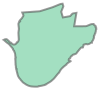

In [23]:
pgh_study_area = pd.read_pickle(new_dir + '/PGH_neighborhoods/pgh_study_area.csv')
pgh_study_area['geometry'][0]

## Pittsburgh Base Road Network Data

The road network data was obtained from Open Street Maps using the python package osmnx. This data was processed in the Build_Street_Network.ipynb file. The oxmnx package allows users to download the Open Street Maps network data in the form of a networkx graph. Users may select the unimodal network of interest, where options include ... For the study, the networks "auto" and "bike" were selected. Once the networkx graph for each of the two unimodal networks was obtained in the Build_Street_Netework.ipynb file, the graph data structure was converted into a nodes csv file and and edges csv file an subsequently stored. These files will be read into this notebook and then converted back to the nx graph structure.

In [27]:
# Read files
# Import driving and biking networks
df_drive_edges = pd.read_csv(new_dir + '/OSM_data/osm_drive_edges.csv')
df_drive_nodes = pd.read_csv(new_dir + '/OSM_data/osm_drive_nodes.csv')
df_bike_edges = pd.read_csv(new_dir + '/OSM_data/osm_bike_edges.csv')
df_bike_nodes = pd.read_csv(new_dir + '/OSM_data/osm_bike_nodes.csv')

# Safety data
crash_edges_bike = pd.read_csv('crash_edge_bike.csv')
crash_edges_drive = pd.read_csv('crash_edge_vehicle.csv')
bikeway_edges = pd.read_csv('bikeway_edges.csv')

# Convert to gdf so we can clip to the study area
gdf_drive_nodes = gpd.GeoDataFrame(data=df_drive_nodes, geometry=gpd.points_from_xy(df_drive_nodes.x, df_drive_nodes.y, crs="EPSG:4326"))
gdf_bike_nodes = gpd.GeoDataFrame(data=df_bike_nodes, geometry=gpd.points_from_xy(df_bike_nodes.x, df_bike_nodes.y, crs="EPSG:4326"))

cols_keep = ['source', 'target', 'speed_kph', 'length', 'highway', 'geometry', 'avg_TT_min']
gdf_drive_edges = edgedf_to_gdf(df_drive_edges, df_drive_nodes, 'source', 'target', 'nodeID')[cols_keep]
gdf_bike_edges = edgedf_to_gdf(df_bike_edges, df_bike_nodes, 'source', 'target', 'nodeID')[cols_keep]
gdf_bike_edges.shape
gdf_drive_edges.shape
gdf_drive_edges.columns

(5468, 7)

(2134, 7)

Index(['source', 'target', 'speed_kph', 'length', 'highway', 'geometry',
       'avg_TT_min'],
      dtype='object')

In [28]:
df_drive_edges.head()

,source,target,maxspeed,access,lanes,highway,speed_kph,junction,osmid,length,ref,bridge,oneway,geometry,name,avg_TT_min
0,104198857,104597622,NaN,NaN,NaN,residential,40.2,NaN,"[11652944, 11691450]",187.389,NaN,NaN,False,"LINESTRING (-79.9492515 40.4282209, -79.949271...","['Alexis Street', 'Four Mile Run Road']",0.279685
1,104198857,105251048,NaN,NaN,NaN,residential,40.2,NaN,265759816,55.610,NaN,NaN,False,"LINESTRING (-79.9492515 40.4282209, -79.949188...",Boundary Street,0.083000
2,104212938,105178623,25 mph,NaN,2,primary,40.2,NaN,1022452902,31.332,NaN,NaN,False,NaN,Beechwood Boulevard,0.046764
3,104212938,104507187,25 mph,NaN,2,secondary,40.2,NaN,54507805,340.742,NaN,NaN,False,"LINESTRING (-79.93450199999999 40.428105, -79....",Beechwood Boulevard,0.508570
4,104212938,5320857537,NaN,NaN,1,motorway_link,47.4,NaN,54507822,244.524,NaN,NaN,True,"LINESTRING (-79.93450199999999 40.428105, -79....",NaN,0.309524


In [29]:
gdf_drive_edges.highway.unique()

array([nan, 'traffic_signals', 'turning_circle', 'stop', 'turning_loop',
       'crossing', 'motorway_junction'], dtype=object)

## Create risk score for each segment 
For the drive network, it is a simple function of the crash rate (per mile). For the bike/scootern network, it is a simple function of speed limit and bikeway type (i.e. whether or not bike lane exists)

In [30]:
def calc_bike_risk_index(row):
    if((row['highway'] == 'cycleway') | (row['bikeway_type'] in (['Bike Lanes','Protected Bike Lane']))):
        risk_idx = 1
    elif(row['highway'] in (['motorway','trunk','trunk_link','primary','primary_link'])):
        risk_idx = 100000
    else:
        risk_idx = 1.2   # this is a parameter to be adjusted. idea is that non-bikelane road is 25% more dangerous
    return risk_idx

In [31]:
# merge the safety data 
gdf_bike_edges = gdf_bike_edges.merge(crash_edges_bike, left_on = ['source','target'], right_on = ['source', 'target'], how = 'left')
gdf_bike_edges.shape
gdf_bike_edges = gdf_bike_edges.merge(bikeway_edges, left_on = ['source','target'], right_on = ['source', 'target'], how = 'left')
gdf_drive_edges = gdf_drive_edges.merge(crash_edges_drive, left_on = ['source','target'], right_on = ['source', 'target'], how = 'left')

(5468, 9)

In [32]:
gdf_drive_edges['crash_count'] = gdf_drive_edges['crash_count'].fillna(0)
gdf_bike_edges['crash_count'] = gdf_bike_edges['crash_count'].fillna(0)

cols_keep = cols_keep = ['source', 'target', 'speed_kph', 'length', 'highway', 'geometry_x', 'avg_TT_min', 'crash_count', 'bikeway_type_source']
gdf_bike_edges = gdf_bike_edges[cols_keep].rename(columns={'bikeway_type_source':'bikeway_type', 'geometry_x':'geometry'})
gdf_bike_edges['bikeway_type'] = gdf_bike_edges['bikeway_type'].fillna('None')

# Add risk index
# Idea: driving roads have a baseline risk index of 1. so do bike lane roads.
# The risk index of a driving road is increased (from the baseline of 1) 
# by a factor of crash_weight * crash_per_meter. a non-bike lane road is deemed 50% more dangerous, so its risk_index is 1.5
# non-bikeable roads have an arbitrarily large risk index
# Drive
crash_weight = 5  # this parameter can be tuned
gdf_drive_edges.loc[:,'crash_per_meter'] = (gdf_drive_edges['crash_count'] / gdf_drive_edges['length'])
#gdf_drive_edges['crash_per_meter'].map({0:1})
gdf_drive_edges.loc[:,'risk_idx'] = 1 + crash_weight * gdf_drive_edges['crash_per_meter']
mapping = dict(zip(gdf_drive_edges.risk_idx, gdf_drive_edges.risk_idx))
mapping[0] = 1
gdf_drive_edges.loc[:,'risk_idx'] = gdf_drive_edges.loc[:,'risk_idx'].map(mapping)
# Bike
#risk_weight = 2
gdf_bike_edges['risk_idx'] = gdf_bike_edges.apply(lambda row: calc_bike_risk_index(row), axis=1)
#gdf_bike_edges['risk_idx'] = risk_weight * gdf_bike_edges['risk_idx']
gdf_bike_edges.loc[gdf_bike_edges.bikeway_type.isin(['Bike Lanes','Protected Bike Lane'])]['risk_idx'].unique() # check

array([1.])

In [33]:
gdf_drive_edges.loc[gdf_drive_edges.crash_count > 1].head(5)

,source,target,speed_kph,length,highway,geometry,avg_TT_min,tot_inj_sum,crash_count,crash_per_meter,risk_idx
0,104198857,104597622,40.2,187.389,NaN,"LINESTRING (-79.94925 40.42822, -79.94954 40.4...",0.279685,3.0,7.0,0.037355,1.186777
1,104198857,105251048,40.2,55.610,NaN,"LINESTRING (-79.94925 40.42822, -79.94910 40.4...",0.083000,0.0,2.0,0.035965,1.179824
3,104212938,104507187,40.2,340.742,NaN,"LINESTRING (-79.93450 40.42811, -79.93799 40.4...",0.508570,1.0,4.0,0.011739,1.058695
4,104212938,5320857537,47.4,244.524,NaN,"LINESTRING (-79.93450 40.42811, -79.93213 40.4...",0.309524,1.0,4.0,0.016358,1.081792
19,104375383,104680982,40.2,46.545,NaN,"LINESTRING (-79.94693 40.42792, -79.94686 40.4...",0.069470,1.0,4.0,0.085938,1.429692


## Generate a function that gives a travel time multiplier as a function of time
This function is a made up, based simply on intuition. It is used for the purpose of testing time-dependency of shortest path in the multimodal network

Text(0.5, 0, 'Time (minutes relative to 07:00AM)')

Text(0, 0.5, 'Travel time multiplier \n (relative to baseline)')

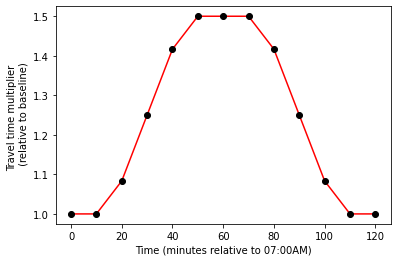

In [34]:
# Here we build the travel time multiplier as a function of time 
# some arbitary piecewise function
x = np.linspace(0, len_period, num_intervals)  # x is time [min past] relative to 07:00 AM
y = np.piecewise(x, [x < 15, ((x>=15) & (x<45)), ((x>=45) & (x<=75)), ((x>75) & (x<105)), x >= 105],
                 [1, lambda x: (0.5/30)*(x - 30) + 1.25, 1.5, lambda x: (-0.5/30)*(x - 90) + 1.25 , 1])
plt.plot(x, y, 'o', color='black', zorder=2);
plt.plot(x, y, color='red', zorder=1);
plt.xlabel('Time (minutes relative to 07:00AM)')
plt.ylabel('Travel time multiplier \n (relative to baseline)')

In [35]:
# use a df to store the parameters that are common by interval
df_drive_cost = pd.DataFrame(index = range(num_intervals), columns=['avg_TT', 'TT_mult', 'risk', 'price', '95_TT'])
df_drive_cost['TT_mult'] = y 
df_drive_cost.shape

(13, 5)

In [36]:
df_drive_nodes.columns

Index(['nodeID', 'y', 'x', 'street_count', 'highway', 'ref', 'geometry'], dtype='object')

In [37]:
G_drive = dfs_to_nx(df_drive_nodes, 'nodeID', 'y', 'x', df_edges=gdf_drive_edges, source_colname='source', target_colname='target')
G_bike = dfs_to_nx(df_bike_nodes, 'nodeID','y', 'x', df_edges=gdf_bike_edges, source_colname='source', target_colname='target')

# testing
# G_drive.nodes[104198595]
# G_drive.edges[(104198595, 104822545)]

In [38]:
# add risk = risk_idx * TT
for e in G_bike.edges:
    G_bike.edges[e]['risk'] = G_bike.edges[e]['risk_idx'] * G_bike.edges[e]['avg_TT_min']

In [39]:
# for e in G_bike.edges:
#     for i in range(num_intervals):
#         G_bike.edges[e]['interval'+str(i)+'_avg_TT_min'] = G_bike.edges[e]['avg_TT_min']
#         G_bike.edges[e]['interval'+str(i)+'_reliability'] = rel_weights['pb'] * G_bike.edges[e]['interval'+str(i)+'_avg_TT_min']

**Drive & bike networks** <br>
Edge attributes so far: speed_kph, length (m), highway type, geometry, avg_TT_min, risk_index

In [40]:
# add avg_TT_min by time interval 
for e in G_drive.edges:
    for i in range(num_intervals):
        G_drive.edges[e]['interval'+str(i)+'_avg_TT_min'] = y[i] * G_drive.edges[e]['avg_TT_min']
#G_drive.edges[(104198595, 104822545)]

In [41]:
len(list(G_drive.edges))

2125

In [42]:
# for attr_name, attr_val in cost_attr_TD.items():
#     nx.set_edge_attributes(G_drive, attr_val, attr_name)
# G_drive.edges[(104198595, 104822545)]

Text(0.5, 1.0, 'Driving Network for Selected Neighborhoods')

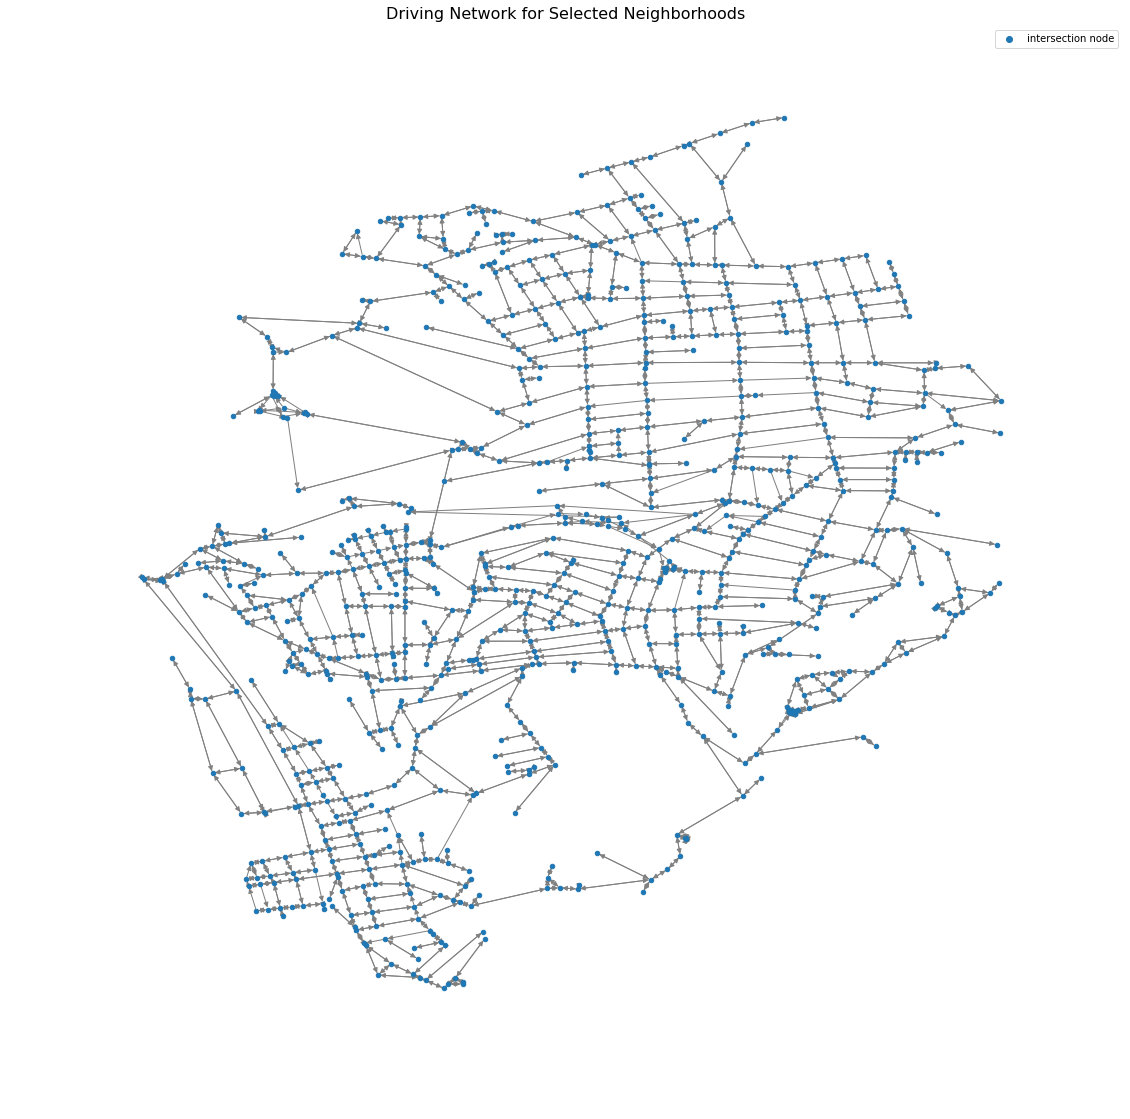

In [43]:
node_cmap = {'intersection node': '#1f77b4'}
ax = draw_graph(G_drive, '#1f77b4', node_cmap, edge_color='gray')
ax.set_title('Driving Network for Selected Neighborhoods', fontsize=16)

## TNC
The TNC graph is assumed to the mimic base driving road network

In [44]:
# add travel time for the drive network
for e in G_drive.edges:
    for i in range(num_intervals):
        G_drive.edges[e]['interval'+str(i)+'_avg_TT_min'] = y[i] * G_drive.edges[e]['avg_TT_min']
        G_drive.edges[e]['interval'+str(i)+'_reliability'] = (rel_weights('pv') * 
                                                             G_drive.edges[e]['interval'+str(i)+'_avg_TT_min'])
        G_drive.edges[e]['interval'+str(i)+'_risk'] = G_drive.edges[e]['risk_idx'] * G_drive.edges[e]['avg_TT_min']

# build the TNC network
G_tnc = G_drive.copy()
nx.set_node_attributes(G_tnc, 't', 'nwk_type')
G_tnc = rename_nodes(G_tnc, 't')

# add TNC price and TT
for e in G_tnc.edges:
    for i in range(num_intervals):
        G_tnc.edges[e]['interval'+str(i)+'_price'] = (TNC_op_ppmin * G_tnc.edges[e]['interval'+str(i)+'_avg_TT_min'] +
                                                      TNC_op_ppmile * miles_in_km * G_tnc.edges[e]['length']/1000)
        
        #G_tnc.edges[e]['interval'+str(i)+'_COST'] = ((b_price * G_tnc.edges[e]['interval'+str(i)+'_price']) +
           # (b_TT * G_tnc.edges[e]['interval'+str(i)+'_avg_TT_min']) + (b_risk *  G_tnc.edges[e]['risk_idx']))
nx.set_edge_attributes(G_tnc, 't', 'mode_type')
#G_tnc.edges[('t104198595', 't104822545')]

In [45]:
cwd

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Code'

## Personal Vehicle 

### Park and Ride Data

In [46]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/ParkRide')
os.chdir(new_dir)
file_name = 'SPCRegPNR.shp'   # https://data.wprdc.org/dataset/regional-park-n-ride-facilities-web-inventory/resource/46692b9c-ad3f-4a29-8deb-5ca4207eb50d
pnr_gdf = read_file(file_name)
pnr_gdf.head(2)
#pnr_gdf.crs
# Transform geometry of edges to the proper coord system
pnr_gdf = pnr_gdf.to_crs(epsg = 4326)
#pnr_gdf.crs

,ID,STATUS,NAME,LOCATION,MUNIC,ZIPCITY,ZIPCODE,COUNTY,X_COORD,Y_COORD,RESTRICT_,CAPACITY,OWNER,PARK_FEE,D_PARK_FEE,M_PARK_FEE,SERV_TRANS,TRANS_OP_1,TRANS_OP_2,geometry
0,1.0,OPEN,OLYMPIA SHOPPING CENTER-WALNUT ST-MCKEESPORT,4313 WALNUT ST.,CITY OF MCKEESPORT,MCKEESPORT,15132,ALLEGHENY,40.32270,-79.83461,TRANSIT ONLY,50,PRIVATE,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1387303.979 367272.753)
1,2.0,OPEN,DUQUESNE-LIBRARY PL AT DUQUESNE BLVD-DUQUESNE,RT 837 (DUQUESNE BLVD.) AT LIBRARY PL.,CITY OF DUQUESNE,DUQUESNE,15110,ALLEGHENY,40.37227,-79.84466,NONE,311,PORT AUTHORITY OF ALLEGHENY COUNTY,NO,0.0,0.0,YES,PORT AUTHORITY OF ALLEGHENY COUNTY,NONE,POINT (1384930.811 385392.023)


In [47]:
# ax = plot_nodes_and_edges([(pnr_gdf, 'blue', 'pnr')], gdf_drive_edges)
# ax.set_title('Park and Ride facilities relative to the study area')
# # observe that no park and ride facilities intersect the study area...
# # confirmation:
# #pnr_clip = gpd.clip(pnr_gdf, pgh_study_area)
# #pnr_clip.shape

In addition to park & ride data (which does not exist within the study area), we can incorporate PGH Parking Zone data. See: https://data.wprdc.org/dataset/pittsburgh-parking-meters-and-payment-points/resource/aefaf190-7f4c-4466-a28b-1b7ce039419d
This data was processed in Parking.ipynb. The data comes in the form of a lat/long coordinate for each parking meter, in addition to parking rate. Over 1000 points exist. To simplify, we grouped by parking zone and took the avg lat-long point. This single point was approximated as only place to park within the parking zone. It can be justified in the sense that, on average, travelers must walk the distance from this representative point to the next node in their journey

In [48]:
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
df_parking = pd.read_pickle('parking_points.csv')
gdf_parking = gpd.GeoDataFrame(data=df_parking, geometry=df_parking.geometry, crs='epsg:4326')
#gdf_parking.crs
len(gdf_parking)
gdf_parking_clip = gpd.clip(gdf_parking, pgh_study_area).reset_index().drop(columns='index')
gdf_parking_clip.insert(0, 'ID', gdf_parking_clip.index)
len(gdf_parking_clip)

57

7

In [49]:
# create graph structure 
# start with base road network
G_pv = G_drive.copy()
nx.set_node_attributes(G_pv, 'pv', 'nwk_type')
G_pv = rename_nodes(G_pv, 'pv')

# set edge price (not time-dep) and total cost (yes time-dep)
for e in G_pv.edges:
    price = pv_ppmile * (G_pv.edges[e]['length'] / meters_in_mile)  # op cost per edge
    G_pv.edges[e]['price'] = price
    price_attr = dict(zip(['interval'+str(i)+'_price' for i in range(num_intervals)], num_intervals * [price]))
    nx.set_edge_attributes(G_pv, {e: price_attr})
nx.set_edge_attributes(G_pv, 'pv', 'mode_type')
#     for i in range(num_intervals):
#         G_pv.edges[e]['interval'+str(i)+'_COST'] = ((b_price * G_pv.edges[e]['price']) +
#             (b_TT * G_pv.edges[e]['interval'+str(i)+'_avg_TT_min']) + (b_risk *  G_pv.edges[e]['risk_idx']))
#G_pv.edges[('pv104198595', 'pv104822545')]

In [50]:
gdf_parking_clip.head()

,ID,zone,latitude,longitude,float_rate,geometry
0,0,323 - Douglas Phillips Lot,40.432617,-79.922537,1.0,POINT (-79.92254 40.43262)
1,1,413 - Squirrel Hill,40.433581,-79.923099,1.5,POINT (-79.92310 40.43358)
2,2,321 - Beacon Bartlett Lot,40.435454,-79.923617,1.0,POINT (-79.92362 40.43545)
3,3,325 - JCC/Forbes Lot,40.437756,-79.923901,1.0,POINT (-79.92390 40.43776)
4,4,322 - Forbes Shady Lot,40.438602,-79.920122,1.0,POINT (-79.92012 40.43860)


In [51]:
# build parking graph
df_park_nodes = gdf_parking_clip[['ID','latitude','longitude']] 
G_park = dfs_to_nx(df_park_nodes, 'ID', 'latitude', 'longitude')
# G_park.nodes[0]
nx.set_node_attributes(G_park, 'k', 'nwk_type')
G_park = rename_nodes(G_park, 'k')
G_park.nodes
   # merge the intersection nodes with the pnr stations. still need to add cnx edges
G_pv = nx.union_all([G_pv, G_park])

NodeView(('k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6'))

In [52]:
def build_cnx_edges(gdf, mode_type, depot_col, nn_col, num_park_hours=8): # b_price, b_TT, b_risk, num_intervals, num_park_hours=4):
    # add connection edges (i.e. connect each depot to nearest neighbor in main relevant graph)
    # add length, parking price, risk, & TT attributes to cnx edges
    #park_price = num_park_hours * park_pphour  # $
    #num_park_hours = 4 if G_type in ['pv', 'z'] else 0 
    
    attr_dict_list = [{'length': gdf.reset_index().iloc[i]['distance'], 
                       'price': ((num_park_hours * gdf.reset_index().iloc[i]['float_rate']) if mode_type in ['pv']
                           else 0),  # rate is hourly
                       'risk_idx': 0,
                       'avg_TT_min': gdf.reset_index().iloc[i]['avg_TT_min'],
                       'mode_type': mode_type,
                       'risk': 0 * gdf.reset_index().iloc[i]['avg_TT_min'],
                       'reliability': rel_weights(mode_type) *  gdf.reset_index().iloc[i]['avg_TT_min']} for i in range(len(gdf))]
    

    # add total cost by time interval (all costs should be same since no time-dependent costs yet)
#     for d in attr_dict_list:
#         cost_dict = dict([('interval'+str(i)+'_COST',
#            (b_price * d['price']) + (b_TT * d['avg_TT_min']) + (b_risk * d['risk_idx'])) for i in range(num_intervals)])
#         d.update(cost_dict)
        
    edges_in = list(zip(gdf[nn_col], gdf[depot_col], attr_dict_list))
    return edges_in
    #G_pv.add_edges_from(edges_into_parking)    

In [53]:
# this is only for edges that time-INdependent. we will update to include an attribute for each time interval
def update_td_edges(edges, num_intervals):
    updated_edges = []
    for e0, e1, attr_dict in edges:
        acopy = attr_dict.copy()
        TT_keys = ['interval'+str(i)+'_avg_TT_min' for i in range(num_intervals)]
        price_keys = ['interval'+str(i)+'_price' for i in range(num_intervals)]
        rel_keys = ['interval'+str(i)+'_reliability' for i in range(num_intervals)]
        risk_keys = ['interval'+str(i)+'_risk' for i in range(num_intervals)]
        TT_td_dict = dict(zip(TT_keys, num_intervals * [attr_dict['avg_TT_min']]))
        price_td_dict = dict(zip(price_keys, num_intervals * [attr_dict['price']]))
        rel_td_dict = dict(zip(rel_keys, num_intervals * [attr_dict['reliability']]))
        risk_td_dict = dict(zip(risk_keys, num_intervals * [attr_dict['risk']]))
        acopy.update(TT_td_dict)
        acopy.update(price_td_dict)
        acopy.update(rel_td_dict)
        acopy.update(risk_td_dict)
        updated_edges.append((e0, e1, acopy))
    return(updated_edges)

In [54]:
# Build parking connection edges
# find the intersection node in the road network that is nearest to the parking meter
nn = nearest_neighbor(gdf_parking_clip, gdf_drive_nodes, 'y', 'x', return_dist=True)
gdf_parking_clip = pd.concat([gdf_parking_clip, nn], axis=1)
gdf_parking_clip.rename(columns={'ID':'park_ID', 'nodeID':'intx_ID'}, inplace=True)
gdf_parking_clip['park_ID'] = gdf_parking_clip.apply(lambda row: 'k'+str(row['park_ID']), axis=1)
gdf_parking_clip['intx_ID'] = gdf_parking_clip.apply(lambda row: 'pv'+str(row['intx_ID']), axis=1)

# SHOULD BE DRIVING SPEED INSTEAD OF WALKING bc drive from road int to off street parking node ***
gdf_parking_clip['avg_TT_min'] = gdf_parking_clip['distance'] / meters_in_mile / drive_speed / 60   # m/(m/mile)/(miles/hr)/60 [s/min]

In [55]:
edges_park_in = build_cnx_edges(gdf_parking_clip, 'pv', 'park_ID', 'intx_ID') # b_price, b_TT, b_risk, num_intervals)
new_cnx_edges = update_td_edges(edges_park_in, num_intervals)
#edges_park_in
G_pv.add_edges_from(new_cnx_edges)

Text(0.5, 1.0, 'Personal Vehicle Network')

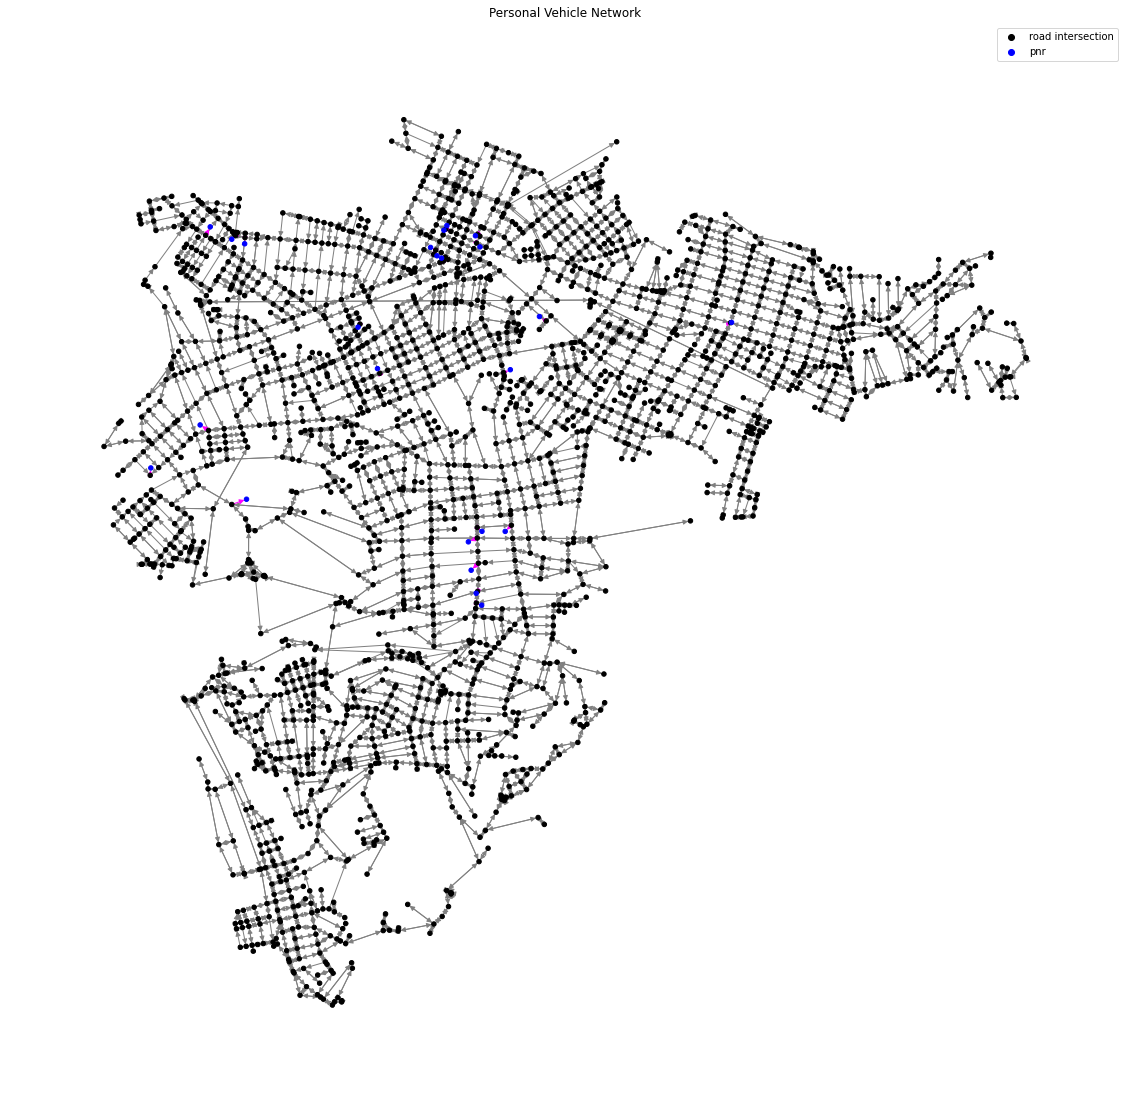

In [67]:
node_color = ['black' if n.startswith('pv') else 'blue' for n in G_pv.nodes]
edge_color = ['grey' if e[0].startswith('pv') and e[1].startswith('pv') else 'magenta' for e in G_pv.edges]
ax = draw_graph(G_pv, node_color, {'road intersection':'black', 'pnr':'blue'}, edge_color)
ax.set_title('Personal Vehicle Network')
# add edge color legend

**Summary up to this point** <br>
We began with the base road network node/link shapefile, which contained intersection nodes and road links. This was clipped to the study area of interest and converted into the networkx graph object after some data processing. The nodes have IDs and position attributes, and the links have IDs and speed limit attributes. The unimodal TNC network was taken to be an exact copy of the base road network. The personal vehicle network was then constructed as an exact copy of the base road network with two additions: 1) park + ride station nodes, and 2) park + ride connector edges. Connector edges are edges that join the station to the nearest road intersection node. It is necessary to construct these connector edges because the park and ride station nodes may not exactly intersect a road network node. It is also important to note that each unimodal network is associated with distinct node and link IDs; although the networks overlap in the physical world, they are considered unique in our model. Distinct node and link IDS are required to solve the multimodal shortest path problem.

## Personal Bike

The personal bike network was obtained in Build_Street_Network.ipynb using the osmnx package. It has already been imported into this notebook in the "Pittsburgh Base Road Network Data" section <br>
Note: the bike network is sufficiently larger than the drive network. When looking at the data extracted from OSM, it appears that the bike network includes many types are streets, such as cycleways and pedestrian-friendly streets, that are expectedly not included in the driving network. The bike network does not include "mototways", which are highways, but it does include other larger roads. If we desire, we may subset the bike network to only incude small roads, cycleways, and pedestrian roads. This will be a judgment call.

In [56]:
G_pb = G_bike.copy()
G_pb = rename_nodes(G_pb, 'pb')
nx.set_node_attributes(G_pb, 'pb', 'nwk_type')
for e in G_pb.edges:
    G_pb.edges[e]['reliability'] = rel_weights('pb') * G_pb.edges[e]['avg_TT_min']
    G_pb.edges[e]['price'] = pb_price
#G_pb.edges[('pb104191960', 'pb104191966')]
new_pb_edges = update_td_edges(G_pb.edges(data=True), num_intervals)
G_pb.add_edges_from(new_pb_edges)
nx.set_edge_attributes(G_pb, 'pb', 'mode_type')

In [57]:
# node_cmap = {'intersection node': 'blue'}
# ax = draw_graph(G_pb, 'blue', node_cmap, edge_color='gray')
# ax.set_title('Personal Bike Network for Selected Neighborhoods', fontsize=16)

## Bikeshare

**Get bikeshare Data**
Healthy Ride depots:  https://data.wprdc.org/dataset/healthyride-stations

In [58]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
os.getcwd()

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data'

In [59]:
filename = 'pgh_bikeshare_depot_q3_2021.csv'
bs_df = pd.read_csv(filename)
bs_df.head()

,Station #,Station Name,# of Racks,Latitude,Longitude
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080
2,1002,Third Ave & Wood St,15,40.439030,-80.001860
3,1003,First Ave & Smithfield St,9,40.437200,-80.000375
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102


**Convert to geo df and clip to selected neighborhoods**

In [60]:
# generate point geometry from x,y coords, so that the GIS clip function can be used to only 
# include depots within the study region
bs_df['geometry'] = gpd.points_from_xy(bs_df.Longitude, bs_df.Latitude, crs="EPSG:4326")
bs_gdf = gpd.GeoDataFrame(bs_df)  # convert to geo df
# Clip the bs node network
gdf_bs_clip = gpd.clip(bs_gdf, pgh_study_area).reset_index().drop(columns=['index'])
gdf_bs_clip.shape

(8, 6)

**Create edge from bikeshare depot to nearest network node** <br>
This is the same procedure as what was used for the park and ride stations

In [61]:
# Build bikeshare connection edges
# find the intersection node in the road network that is nearest to the parking meter
nn = nearest_neighbor(gdf_bs_clip, gdf_bike_nodes, 'y', 'x', return_dist=True)
gdf_bs_clip = pd.concat([gdf_bs_clip, nn], axis=1, join='outer').rename(columns={'Station #':'depot_ID'})
gdf_bs_clip['depot_ID'] = gdf_bs_clip.apply(lambda row: 'bsd'+str(row['depot_ID']), axis=1)
gdf_bs_clip['nodeID'] = gdf_bs_clip.apply(lambda row: 'bs'+str(row['nodeID']), axis=1)
gdf_bs_clip['avg_TT_min'] = gdf_bs_clip['distance'] / bike_speed / 60   # m/(m/s)/60 [min]

In [62]:
edges_bs_in = build_cnx_edges(gdf_bs_clip, 'bs', 'depot_ID', 'nodeID') #b_price, b_TT, b_risk, num_intervals)
intx_node, bsd_node, attr_dict = zip(*edges_bs_in)
edges_bs_out = list(zip(bsd_node, intx_node, attr_dict))

In [63]:
# update cnx edges so that they include price/TT/reliability attributes for each interval
new_edges_bs_in = update_td_edges(edges_bs_in, num_intervals)
new_edges_bs_out = update_td_edges(edges_bs_out, num_intervals)

### Convert to networkx graph

In [64]:
# first add intersection nodes and rename
G_bs = G_pb.copy()  
prefix = 'bs'
nx.set_node_attributes(G_bs, 'bs', 'nwk_type')
G_bs = rename_nodes(G_bs, prefix)

# set edge price and then add total cost by time interval
for e in G_bs.edges:
    G_bs.edges[e]['price'] = G_bs.edges[e]['avg_TT_min'] * bs_price
nx.set_edge_attributes(G_bs, 'bs', 'mode_type')
#     for i in range(num_intervals):
#         G_bs.edges[e]['interval'+str(i)+'_COST'] = ((b_price * G_bs.edges[e]['price']) +
#             (b_TT * G_bs.edges[e]['avg_TT_min']) + (b_risk *  G_bs.edges[e]['risk_idx']))   

In [65]:
# create bs depot graph, then add to the regular bike network 
cols_keep = ['depot_ID', 'Latitude', 'Longitude']
G_bsdepot = dfs_to_nx(gdf_bs_clip[cols_keep], 'depot_ID', 'Latitude', 'Longitude')
G_bsdepot = rename_nodes(G_bsdepot, 'bsd')
nx.set_node_attributes(G_bsdepot, 'bsd', 'nwk_type')
G_bs = nx.union_all([G_bs, G_bsdepot]) 

# add depot_cnx edges
G_bs.add_edges_from(new_edges_bs_in + new_edges_bs_out)

In [66]:
len(list(G_bs.edges))

5405

In [67]:
# G_bs.edges[('bs104191960', 'bs104191966')]  # traversal edges
# G_bs.edges[('bsd1027', 'bs1796211491')]  # cnx edge

**This is the graph that will be used to find precomputed edge weights of shortcut edges between depot nodes**

Text(0.5, 1.0, 'Bikeshare Network')

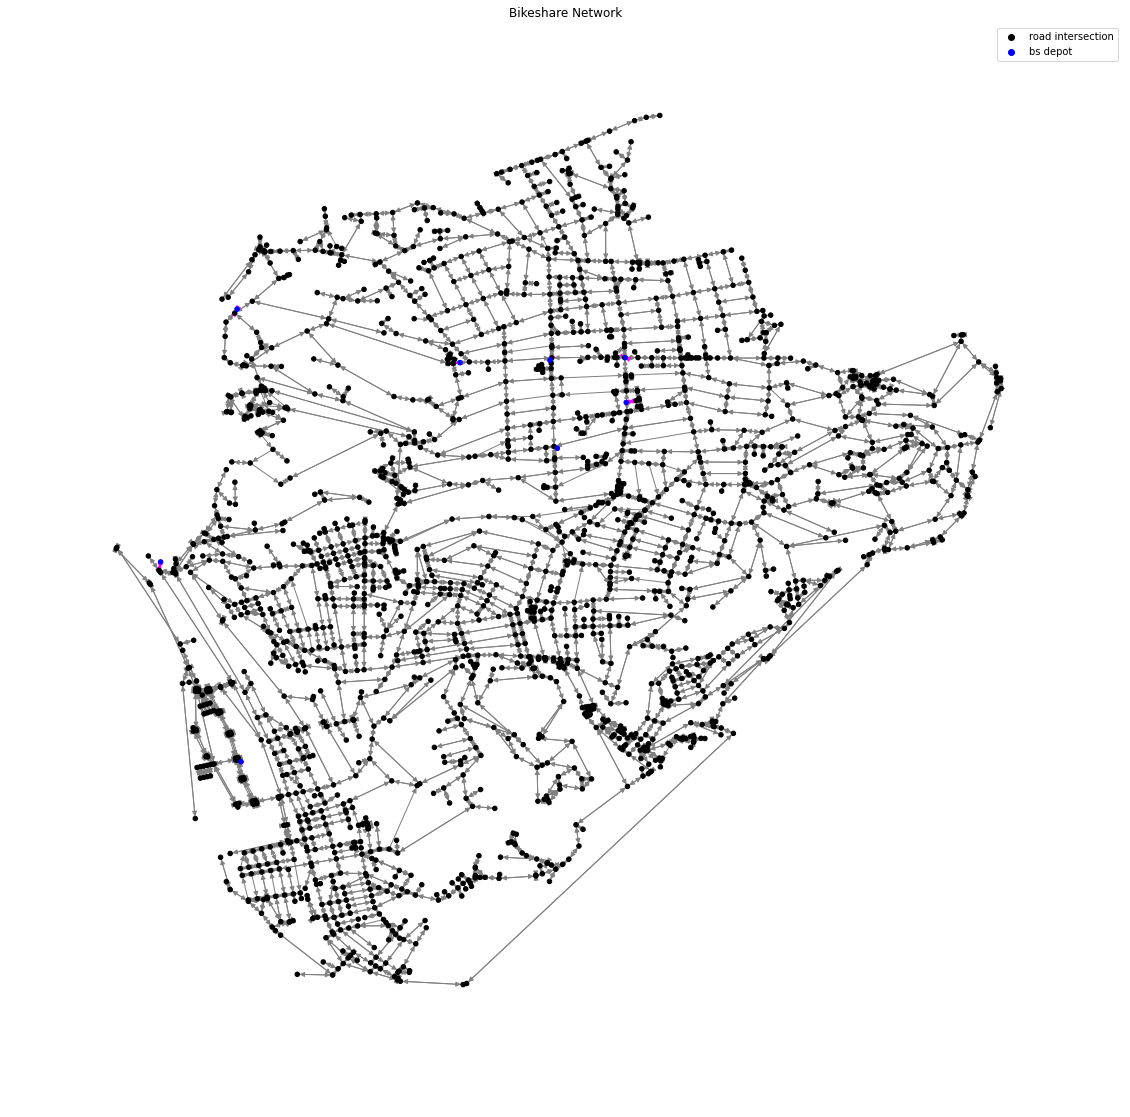

In [130]:
node_color = ['blue' if n.startswith('bsd') else 'black' for n in G_bs.nodes]
edge_color = ['magenta' if (e[0].startswith('bsd') or e[1].startswith('bsd')) else 'gray' for e in G_bs.edges]
ax = draw_graph(G_bs, node_color, {'road intersection':'black', 'bs depot':'blue'}, edge_color)
ax.set_title('Bikeshare Network')
# TO DO: add legend for edge color. See small network for example

### Precompute the bikeshare network

This is the graph that will be used in the supernetwork

In [144]:
# Now, define the cost function as b_tt*TT + ... + b_disc * disc, where disc = disc_weight * avg_TT
for e in G_bs.edges:
    interval0_COST = (b_TT * G_bs.edges[e]['interval0_avg_TT_min'] + 
                      + b_risk *  G_bs.edges[e]['interval0_risk'] 
                      + b_rel * G_bs.edges[e]['interval0_reliability'] 
                      + b_price * G_bs.edges[e]['interval0_price'] + 
                      + b_disc * discomf_weight_bike * G_bs.edges[e]['interval0_avg_TT_min'])
    G_bs.edges[e[0], e[1]]['interval0_COST'] = interval0_COST

In [145]:
#G_bs.edges[('bs104191960', 'bs104191966')]

In [146]:
G_bs_pre = dfs_to_nx(gdf_bs_clip, 'depot_ID', 'Latitude', 'Longitude')  # only include depots
G_bs_pre = rename_nodes(G_bs_pre, 'bs')
nx.set_node_attributes(G_bs_pre, 'bs', 'nwk_type')

bs_depot_pairs = list(itertools.permutations(list(G_bs_pre.nodes), 2))
# Add shortcut b/w all depot edges. Don't calculate shortcut edge weight yet; will be done in subsequent step
for e in bs_depot_pairs:
    G_bs_pre.add_edge(*e)
#draw_graph(G_bs_pre, 'blue', {'bs depot': 'blue'}, 'gray')

In [147]:
G_bs_pre.nodes

NodeView(('bs49201', 'bs1085', 'bs1037', 'bs1070', 'bs1069', 'bs49251', 'bs49261', 'bs1068'))

In [148]:
print('Number of shortcut edges = ', (len(G_bs_pre.nodes)*(len(G_bs_pre.nodes)-1)))
len(G_bs_pre.edges)  # checks out

Number of shortcut edges =  56


56

In [149]:
## Precompute bikeshare shortcut edge cost 

In [150]:
# Find the depots in G_bs
depot_nodes = [n for n in G_bs.nodes if n.startswith('bsd') ]
depot_pairs = list(itertools.permutations(depot_nodes, 2))
#cost_keys = ['interval' + str(i) + '_COST' for i in range(num_intervals)]

# Precompute the shortest path between each pair of depot nodes 
for e in depot_pairs:
    # find shortest path b/w depot nodes using 'interval0_COST' as the weight
    # observe that the bs network is time-indep so it does not matter which cost we choose to use
    try:
        sp = nx.dijkstra_path(G_bs, e[0], e[1], 'interval0_COST')  
        sp_edges = [(sp[i], sp[i+1]) for i in range(len(sp)-1)]
        total_cost = sp_total_cost(G_bs, sp_edges, 'interval0_COST') 
    except:  # no path between the two depots, thus the cost is arbitarily large (*this is happening with bsd1041*)
        total_cost = 100000
    # make the cost dict, which is constant by time interval
    #bs_cost_dict = dict(zip(cost_keys, [total_cost]*num_intervals))
    # add cost for the depot-depot edge. remember that in the precomp network, the bs depot node is referred to
    # by a 'bs' prefix
    G_bs_pre.edges[e[0].replace('bsd','bs'), e[1].replace('bsd','bs')]['interval0_COST'] = total_cost
    #nx.set_edge_attributes(G_bs_pre, {(e[0].replace('bsd','bs'), e[1].replace('bsd','bs')): bs_cost_dict})
    
# define edges of initial graph as traversal
# traversal edges
nx.set_edge_attributes(G_bs_pre, 'traversal', 'type')  # real graph
nx.set_edge_attributes(G_bs_pre, 'bs', 'mode_type')  # real graph
#nx.set_edge_attributes(G_u_adj, 'traversal', 'type')  # adj graph

## Public Transit

GTFS data was processed in Public_Transit_Data.ipynb. Here we read the processed data.

In [75]:
# Change directory to location of data
new_dir = cwd.replace('Code','Data/PortAuthority/GTFS/')
os.chdir(new_dir)
filename = 'PT_route_data.csv'   

In [76]:
os.getcwd()

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data/PortAuthority/GTFS'

The 'PT_route_data.csv' file, to be read into a dataframe called pt_df, provides the sequence of stop_ids that for all (route_id-direction_id) pairs

In [77]:
pt_df = pd.read_pickle(filename)  # read file
pt_df.columns = ['route_id', 'direction_id', 'stop_sequence', 'point_sequence']
#pt_df["rt_node_id"] = 'rt' + '_' + pt_df['route_id'] + '_' + pt_df['direction_id'].astype(str)
pt_df['geometry'] = pt_df['point_sequence'].apply(lambda x: LineString(x))  # add linestring data for routing
pt_gdf = gpd.GeoDataFrame(pt_df, crs='EPSG:4326')  # convert to gdf 
pt_gdf_clip = gpd.clip(pt_gdf, pgh_study_area)  # clip to study area
pt_gdf_clip.head()

,route_id,direction_id,stop_sequence,point_sequence,geometry
63,53L,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...","LINESTRING (-79.94983 40.42841, -79.93857 40.4..."
64,53L,1,"[21187, 20906, 21465, 9616, 21224, 21225, 2122...","[POINT (-79.93244199999999 40.361767), POINT (...","LINESTRING (-79.91966 40.41168, -79.92297 40.4..."
61,52L,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...","LINESTRING (-79.94983 40.42841, -79.93857 40.4..."
81,61A,0,"[20856, 1664, 20293, 3241, 3242, 20976, 20977,...","[POINT (-80.000658 40.440792), POINT (-79.9988...","MULTILINESTRING ((-79.94690 40.44437, -79.9422..."
71,57,0,"[43, 10147, 12177, 11669, 12178, 12180, 12181,...","[POINT (-80.004786 40.439575), POINT (-80.0035...","MULTILINESTRING ((-79.95781 40.42952, -79.9556..."


In [78]:
# # Testing: 
# temp = pt_gdf.loc[(pt_gdf.route_id == '61C') & (pt_gdf.direction_id == 1)]
# #fig, ax = plt.subplots(figsize=(10,10))
# ax = plot_nodes_and_edges([(gdf_drive_nodes, 'black', 'intersection nodes')], gdf_drive_edges)
# temp.plot(ax=ax, zorder=2, color='magenta', label='bus route')
# xs = [point.x for point in temp['point_sequence'].values[0]]
# ys = [point.y for point in temp['point_sequence'].values[0]]
# ax.scatter(xs, ys, color='blue', label = 'bus stops')
# ax.legend()
# ax.set_title('Single Route and Associated Stops, superimposed over study area')

### Convert to networkx graph

**Nodes**

In [79]:
# first we need the coordinates of all the bus stops 
# we will use the stops.txt file directly from GTFS
stops_df = pd.read_csv('stops.txt')
stops_df.head(3)

# Convert to gdf, but don't clip to study area. Might be the case where the stops on a route go outside the study 
# area but then come back into the study area. If we remove the stops outside the study area, bus route will be 
# inconsistent with reality
stops_df['geometry'] = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat, crs='EPSG:4326')
stops_gdf = gpd.GeoDataFrame(stops_df, crs='EPSG:4326').rename(columns={'stop_lat':'y', 'stop_lon':'x'})
len(stops_gdf.stop_id.unique())

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,4875,4875,ARLINGTON AVE + FREDERICK,NaN,40.417694,-79.982614,01,NaN,NaN,NaN,NaN,0
1,4876,4876,ARLINGTON AVE + KOEHLER,NaN,40.417637,-79.984507,01,NaN,NaN,NaN,NaN,0
2,4877,4877,ARLINGTON AVE + S 18TH,NaN,40.417582,-79.986232,01,NaN,NaN,NaN,NaN,0


6842

6842

<AxesSubplot:>

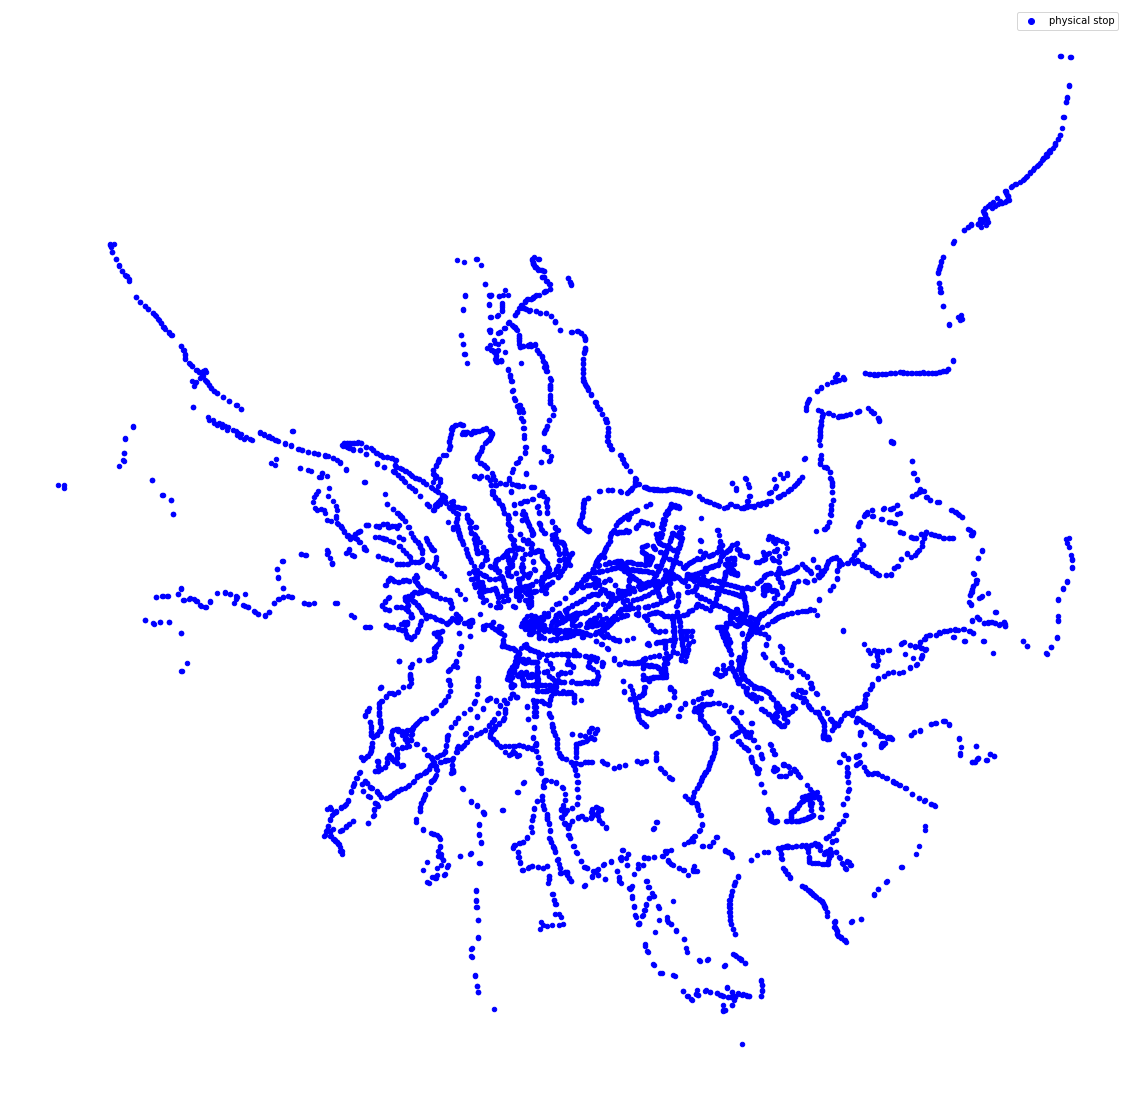

In [80]:
# convert physical stop nodes to nx graph 
G_pt = dfs_to_nx(stops_gdf[['stop_id','x','y']], 'stop_id', 'y', 'x')
G_pt = rename_nodes(G_pt, 'ps')
nx.set_node_attributes(G_pt, 'pt', 'nwk_type')
len(list(G_pt.nodes))
draw_graph(G_pt, 'blue', {'physical stop':'blue'}, 'grey')

**Now add route nodes:** 
Use df_traversal time to see which routes use a physical stop 

In [81]:
df_headway = pd.read_csv('PT_headway.csv')  # how long between bus arrivals (for a given route-dir pair)
df_traversal_time = pd.read_csv('PT_traversal_times.csv')  # how long a bus takes to traverse an edge b/w two successive stops
df_headway['route_node_id'] = 'rt' + df_headway['stop_id'].astype('str') + '_' + df_headway['route_id'] + '_' + df_headway['direction_id'].astype(str) 
df_traversal_time['route_node_id'] = 'rt' + df_traversal_time['stop_id'].astype('str') + '_' + df_traversal_time['route_id'] + '_' + df_traversal_time['direction_id'].astype(str) + '_' + df_traversal_time['stop_sequence'].astype(str)
df_headway.head(2)
df_traversal_time.head(5)  
# route node ID includes the stop sequence ID b/c appears to be the case that a single (route-dir-stop) triple
# is repeated, meaning the route-dir passes through the stop more than once on its path
# example: routeID = P16, dir = 1, stopID = 15474

# Some route stops have NaN headway times. That is because there is no trip that passes through the stop within the 
# specified 7-9am interval OR only one trip passes through the stop during the interval
# If that is the case, we will specify that the stop has some a headway time equal to the length of the interval
# (2 hours = 120 min) to prevent routing algorithm from choosing a route with this boarding edge included
null_mask = df_headway.headway_min.isnull().values
df_headway.loc[null_mask, 'headway_min'] = 120 # minutes
df_headway.loc[null_mask].head(3)
#df_traversal_time.loc[(df_traversal_time.route_id == '87') & (df_traversal_time.direction_id == 1) ]
#df_traversal_time.loc[df_traversal_time.route_node_id == 'rt15474_P16_1']


,route_id,direction_id,stop_id,headway_min,route_node_id
0,1,1,5560,30.000000,rt5560_1_1
1,1,1,12626,30.666667,rt12626_1_1


,route_id,direction_id,stop_sequence,stop_id,traversal_time,route_node_id
0,1,1,1,20817,NaN,rt20817_1_1_1
1,1,1,2,16595,80.0,rt16595_1_1_2
2,1,1,3,21344,21.0,rt21344_1_1_3
3,1,1,4,12830,31.0,rt12830_1_1_4
4,1,1,5,12634,48.0,rt12634_1_1_5


,route_id,direction_id,stop_id,headway_min,route_node_id
340,12,1,17587,120.0,rt17587_12_1
1082,19L,0,15287,120.0,rt15287_19L_0
1083,19L,0,22729,120.0,rt22729_19L_0


In [82]:
# associate a route node to a stopID along with its physical coordinates
route_nodes_df = df_traversal_time.merge(stops_df, how='left', on='stop_id')[['route_id','direction_id','stop_id', 'route_node_id', 'stop_lat', 'stop_lon']]
route_nodes_gdf = gpd.GeoDataFrame(data=route_nodes_df, 
                                   geometry = gpd.points_from_xy(route_nodes_df['stop_lon'], route_nodes_df['stop_lat']),
                                   crs='EPSG:4326').rename(columns={'stop_lat':'y', 'stop_lon':'x'})
route_nodes_gdf.head(2)

# route node is of the form: rt + stop + route_id + direction_id + stop_sequence_num

,route_id,direction_id,stop_id,route_node_id,y,x,geometry
0,1,1,20817,rt20817_1_1_1,40.600684,-79.757112,POINT (-79.75711 40.60068)
1,1,1,16595,rt16595_1_1_2,40.600704,-79.756126,POINT (-79.75613 40.60070)


In [83]:
# build route node graph
G_rt = dfs_to_nx(route_nodes_gdf, 'route_node_id', 'y', 'x')
nx.set_node_attributes(G_rt, 'rt', 'nwk_type')
# combine the physical stop nodes with route nodes
G_pt = nx.union_all([G_pt, G_rt])  

In [84]:
# check that all nodes either physical stop or route
for n in list(G_pt.nodes):
    if (not n.startswith('ps')) and (not n.startswith('rt')):
        print(n)

Now for each node, we know its position as well as which route-dir pairs run through it.
This will be important when building transfer edges and deconstructing the shortest path

**Edges**

Now we need to add route edges and boarding/alighting edges. Consider the outbound Forbes/Morewood stop and the buses 61A, 61B, 61C, and 61D. For the Forbes/Morewood physical stop, we should have 4 route nodes to represent the 4 bus lines. Each route node should be connected to the physical stop node by a pair of boarding and alighting edges. All four bus lines travel to the Forbes/Murray physical stop. Ignore the intermediate stops for now. Then we would need to add 4 route edges between Forbes/Morewood and Forbes/Murray, one for each bus line. Similarly, the physical stop Forbes/Murray has 4 route nodes, one for each bus line.

This brings to light another point related to transfer edges. Consider the following example: a person boards the 61A at Forbes/Morewood and then transfers to the 61C and Forbes/Murray to continue along Murray. Even though there is no walking cost associated with the transfer (as it occurs at the same physical stop), is there an inconvenience cost that needs to be incorporated? 

In [85]:
# recall that a route node ID is defined this way: 'rt'+'stop_id'+'_'+'rt_id'+'_'+'dir_id'
# ex: rt12123_57_0
# this is the format we need to match when creating route edges

In [86]:
# df_ss gives us the stops (as a list) associated with a route-dir pair
df_ss = df_traversal_time.groupby(['route_id','direction_id']).agg({'stop_id':list, 'stop_sequence':list}).reset_index()
df_ss['id_seq'] = df_ss.apply(lambda x: list(zip(x.stop_id, x.stop_sequence)), axis=1)
df_ss.head(2)
df_traversal_time.loc[(df_traversal_time.route_id == "64") & (df_traversal_time.direction_id == 0)].head(3)

,route_id,direction_id,stop_id,stop_sequence,id_seq
0,1,0,"[1407, 1408, 180, 213, 214, 215, 216, 1796, 20...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[(1407, 2), (1408, 3), (180, 4), (213, 5), (21..."
1,1,1,"[20817, 16595, 21344, 12830, 12634, 12635, 126...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[(20817, 1), (16595, 2), (21344, 3), (12830, 4..."


,route_id,direction_id,stop_sequence,stop_id,traversal_time,route_node_id
5674,64,0,1,18150,NaN,rt18150_64_0_1
5675,64,0,2,22208,34.0,rt22208_64_0_2
5676,64,0,3,1149,47.0,rt1149_64_0_3


In [87]:
# Build route edges 
route_dir_id_list = list(zip(df_ss.route_id, df_ss.direction_id))  # list of route-dir pairs

for i,s in enumerate(df_ss.id_seq):   # s is a list of (stop_id, stop_seq) tuples
    #stop_ids = df_ss.stop_id  #list(zip(*s))[0]  # list of sequential stop IDs along the route
    route_nodes = ['rt'+stop_id + '_' + route_dir_id_list[i][0] + '_' + 
                      str(route_dir_id_list[i][1]) + '_' + str(stop_seq) for stop_id, stop_seq in s]
    # build route edge of the form: "rt" + stop_id + route_id + dir_id + stop_seq_num
    route_edges = list(zip(route_nodes[:len(route_nodes)], route_nodes[1:len(route_nodes)+1]))
    route_edges_attr = []
    # add travel time attribute. need to look it up in the df_traversal_time dataframe
    for e in route_edges:
        trav_time_sec = df_traversal_time.loc[df_traversal_time['route_node_id'] == e[1]][
            'traversal_time'].values[0]   # traversal time from GTFS data
        # add pure attributes
        attr_dict = {'avg_TT_min': trav_time_sec/60, 
                     'price': 0, 
                     'reliability': rel_weights('pt') * trav_time_sec/60, 
                     'risk_idx':1,
                     'risk': 1 * trav_time_sec/60}  # equate risk index of edge to the index of the least-free driving segment
        
        # add total cost by time interval (all costs should be same since no time-dependent costs yet)
        
#         cost_dict = dict([('interval'+str(i)+'_COST',
#                            (b_price * attr_dict['price']) + (b_TT * attr_dict['avg_TT_min']) +
#                                (b_risk * attr_dict['risk_idx'])) for i in range(num_intervals)])
#         attr_dict.update(cost_dict)
        route_edges_attr.append((e[0], e[1], attr_dict))
    new_route_edges = update_td_edges(route_edges_attr, num_intervals)
    G_pt.add_edges_from(new_route_edges)  # add route edges to the PT graph, along with attriutes/cost
nx.set_edge_attributes(G_pt, "pt", 'mode_type')

In [88]:
# check
len(G_pt.nodes) 
len(G_pt.edges)
route_edges_attr

17960

10929

[('rt10129_Y49_1_1',
  'rt10078_Y49_1_2',
  {'avg_TT_min': 2.183333333333333,
   'price': 0,
   'reliability': 3.275,
   'risk_idx': 1,
   'risk': 2.183333333333333}),
 ('rt10078_Y49_1_2',
  'rt10130_Y49_1_3',
  {'avg_TT_min': 0.8833333333333333,
   'price': 0,
   'reliability': 1.325,
   'risk_idx': 1,
   'risk': 0.8833333333333333}),
 ('rt10130_Y49_1_3',
  'rt10131_Y49_1_4',
  {'avg_TT_min': 0.5833333333333334,
   'price': 0,
   'reliability': 0.875,
   'risk_idx': 1,
   'risk': 0.5833333333333334}),
 ('rt10131_Y49_1_4',
  'rt9447_Y49_1_5',
  {'avg_TT_min': 1.6,
   'price': 0,
   'reliability': 2.4,
   'risk_idx': 1,
   'risk': 1.6}),
 ('rt9447_Y49_1_5',
  'rt21463_Y49_1_6',
  {'avg_TT_min': 0.6833333333333333,
   'price': 0,
   'reliability': 1.025,
   'risk_idx': 1,
   'risk': 0.6833333333333333}),
 ('rt21463_Y49_1_6',
  'rt16281_Y49_1_7',
  {'avg_TT_min': 1.0666666666666667,
   'price': 0,
   'reliability': 1.6,
   'risk_idx': 1,
   'risk': 1.0666666666666667}),
 ('rt16281_Y49_1_7

In [89]:
df_headway.head(2)

,route_id,direction_id,stop_id,headway_min,route_node_id
0,1,1,5560,30.000000,rt5560_1_1
1,1,1,12626,30.666667,rt12626_1_1


In [90]:
# add boarding and alighting edges. avg_TT_min is the waiting time 
# add time to board and time to alight? just a few seconds, so will be negligible probably 
ba_edges = []
for n in list(G_pt.nodes):
    if n.startswith('rt'):   # is a route node
        # Find associated physical stop
        split_route_node = n.split('_')
        phys_stop = 'ps' + re.sub('\D', '', (split_route_node[0]))    # re.sub('\D', '', string) removes letters from string
        
        # Find headway associated with the route-dir-stop
        stop_route_dir_id = split_route_node[0] + '_' + split_route_node[1] + '_' + split_route_node[2]  # remove stop sequence number
        headway_min = df_headway.loc[df_headway['route_node_id'] == stop_route_dir_id][ 
             'headway_min'].values[0]  # headway in minutes
        
        # BOARDING edges
        e_board = (phys_stop, n)
         # add price of one-way fare and waiting cost as headway/2; # call waiting cost "avg_TT_min" for sake of consistency in attribute definitions
        attr_dict = {'avg_TT_min': headway_min/2, 'price':2.75, 
                     'reliability': rel_weights('pt') * headway_min/2, 'risk_idx':0, 'risk': 0,
                     'mode_type':'board'}  # observe no risk
        ba_edges.append((e_board[0], e_board[1], attr_dict)) 
         
        # ALIGHTING edges 
        e_alight = (n, phys_stop)
        # alighting edge has price = 0 and TT = 0 ?
        attr_dict = {'avg_TT_min': 0, 'price':0, 'reliability': 1*0, 'risk_idx':0, 'risk':0, 'mode_type':'alight'}
        ba_edges.append((e_alight[0], e_alight[1], attr_dict))

new_ba_edges = update_td_edges(ba_edges, num_intervals)
G_pt.add_edges_from(new_ba_edges)  # add board/alight edges to the graph

In [91]:
#ba_edges[:2]  # test
#G_pt.edges[('ps20817','rt20817_1_1_1')]
# len(ba_edges)

In [86]:
# offset the geometry of the route nodes, for visualization purposes
for n in G_pt.nodes:
    if n.startswith('rt'):
        G_pt.nodes[n]['pos'] = (G_pt.nodes[n]['pos'][0] + 0.001, G_pt.nodes[n]['pos'][1] + 0.001)

**Draw the graph, nodes and route edges included** <br>
Confirm that traversal edges run between route nodes boarding/alighting edges run between physical stops and route nodes <br>
*Note*: Since many route nodes may be associated with a single physical stop, the graph below will have overlapping route nodes and overlapping boarding/alighting edges

In [90]:
# node_color = ['blue' if n.startswith('ps') else 'red' for n in G_pt.nodes]
# node_cmap = {'phsyical stop':'blue', 'route node':'red'}
# ax = draw_graph(G_pt, node_color, node_cmap, 'gray')
# ax.set_title('PT graph with physical stops and offset route nodes')

In [91]:
# # add link IDs
# prev_max_linkID = max(list(nx.get_edge_attributes(G_bs_pre, 'link_ID').values()))
# prev_max_linkID
# set_link_IDs(G_pt, prev_max_linkID)

## Scooter

In [92]:
G_sc = G_pb.copy()
G_sc = rename_nodes(G_sc, 'sc')
nx.set_node_attributes(G_sc, 'sc', 'nwk_type')
nx.set_edge_attributes(G_sc, 'sc', 'mode_type')

# update the average TT and price. risk_idx is same as that for the bike network
for e in G_sc.edges:
    G_sc.edges[e]['avg_TT_min'] = G_sc.edges[e]['length'] / scoot_speed / 60 
    G_sc.edges[e]['price'] = scoot_ppmin * G_sc.edges[e]['avg_TT_min']
    G_sc.edges[e]['reliability'] = rel_weights('sc') *  G_sc.edges[e]['avg_TT_min']
    G_sc.edges[e]['risk'] = G_sc.edges[e]['risk_idx'] *  G_sc.edges[e]['avg_TT_min']
# update td edges
new_scoot_edges = update_td_edges(G_sc.edges(data=True), num_intervals)
G_sc.add_edges_from(new_scoot_edges)

In [93]:
#G_sc.edges[('sc104191960', 'sc104191966')]

**Subsequently: generate historical scooter location data, to be used in assignment of transfer edge costs**

## Zipcar

In [94]:
# read file, convert to gdf
new_dir = cwd.replace('Code','Data/')
os.chdir(new_dir)
df_zip = pd.read_csv('Zipcar_Depot.csv')
zip_gdf = gpd.GeoDataFrame(data=df_zip, geometry=df_zip['WKT'].apply(wkt.loads), crs='EPSG:4326').reset_index()[['index','geometry']]
zip_gdf['x'] = zip_gdf.geometry.x
zip_gdf['y'] = zip_gdf.geometry.y
zip_gdf_clip = gpd.clip(zip_gdf, pgh_study_area)

In [95]:
#G_z.edges[('z104198595', 'z104822545')]

In [96]:
# convert to nx graph
G_zd = dfs_to_nx(zip_gdf_clip, 'index', 'y', 'x')
G_zd = rename_nodes(G_zd, 'zd')  # zip depot nodes
nx.set_node_attributes(G_zd, 'zd', 'nwk_type')
G_z = G_drive.copy()   # copy of the driving network
G_z = rename_nodes(G_z, 'z')
nx.set_edge_attributes(G_z, 'z', 'mode_type')
G_z = nx.union_all([G_z, G_zd])

# add price and risk attributes. TT/reliability attrs already included in G_drive graph, which we have copied
for e in G_z.edges:
    for i in range(num_intervals):
        G_z.edges[e]['interval'+str(i)+'_price'] = zip_ppmin * G_z.edges[e]['interval'+str(i)+'_avg_TT_min']

# also add parking nodes
G_park_z = rename_nodes(G_park, 'kz')
G_z = nx.union_all([G_z, G_park_z])

In [97]:
# Build parking connection edges
# find the intersection node in the road network that is nearest to the parking meter
nn = nearest_neighbor(zip_gdf_clip, gdf_drive_nodes, 'y', 'x', return_dist=True)
zip_gdf_clip = pd.concat([zip_gdf_clip.reset_index().drop(columns='level_0'), nn], axis=1, join='outer').rename(columns={'index':'depot_ID'})
zip_gdf_clip['depot_ID'] = zip_gdf_clip.apply(lambda row: 'zd'+str(row['depot_ID']), axis=1)
zip_gdf_clip['nodeID'] = zip_gdf_clip.apply(lambda row: 'z'+str(row['nodeID']), axis=1)
zip_gdf_clip['avg_TT_min'] = zip_gdf_clip['distance'] / meters_in_mile / drive_speed / 60   # m/(m/mile)/(miles/hr)/60 [s/min]

In [98]:
# build cnx edges from depot to z network i.e. only include edges_out
#edges_park_in = build_cnx_edges(gdf_parking_clip, 'pv', 'park_ID', 'intx_ID', 'pv')
edges_zd_in = build_cnx_edges(zip_gdf_clip, 'z', 'depot_ID', 'nodeID') #, b_price, b_TT, b_risk, num_intervals, 0)
intx_node, zd_node, attr_dict = zip(*edges_zd_in)
edges_zd_out = list(zip(zd_node, intx_node, attr_dict))

In [99]:
# Build edges from z (intx) to k (parking)
# Actually we have already done this. We just need to replace the name of the edge
zip_edges_park_in = []
for e0, e1, attr_dict in edges_park_in:
    attr_dict['mode_type'] = 'z'
    zip_edges_park_in.append((e0.replace('pv','z'), e1.replace('k','kz'), attr_dict))

new_edges_zd_out = update_td_edges(edges_zd_out, num_intervals)
new_zip_edges_park_in = update_td_edges(zip_edges_park_in, num_intervals)

G_z.add_edges_from(new_edges_zd_out + new_zip_edges_park_in)

Text(0.5, 1.0, 'Zipcar Network')

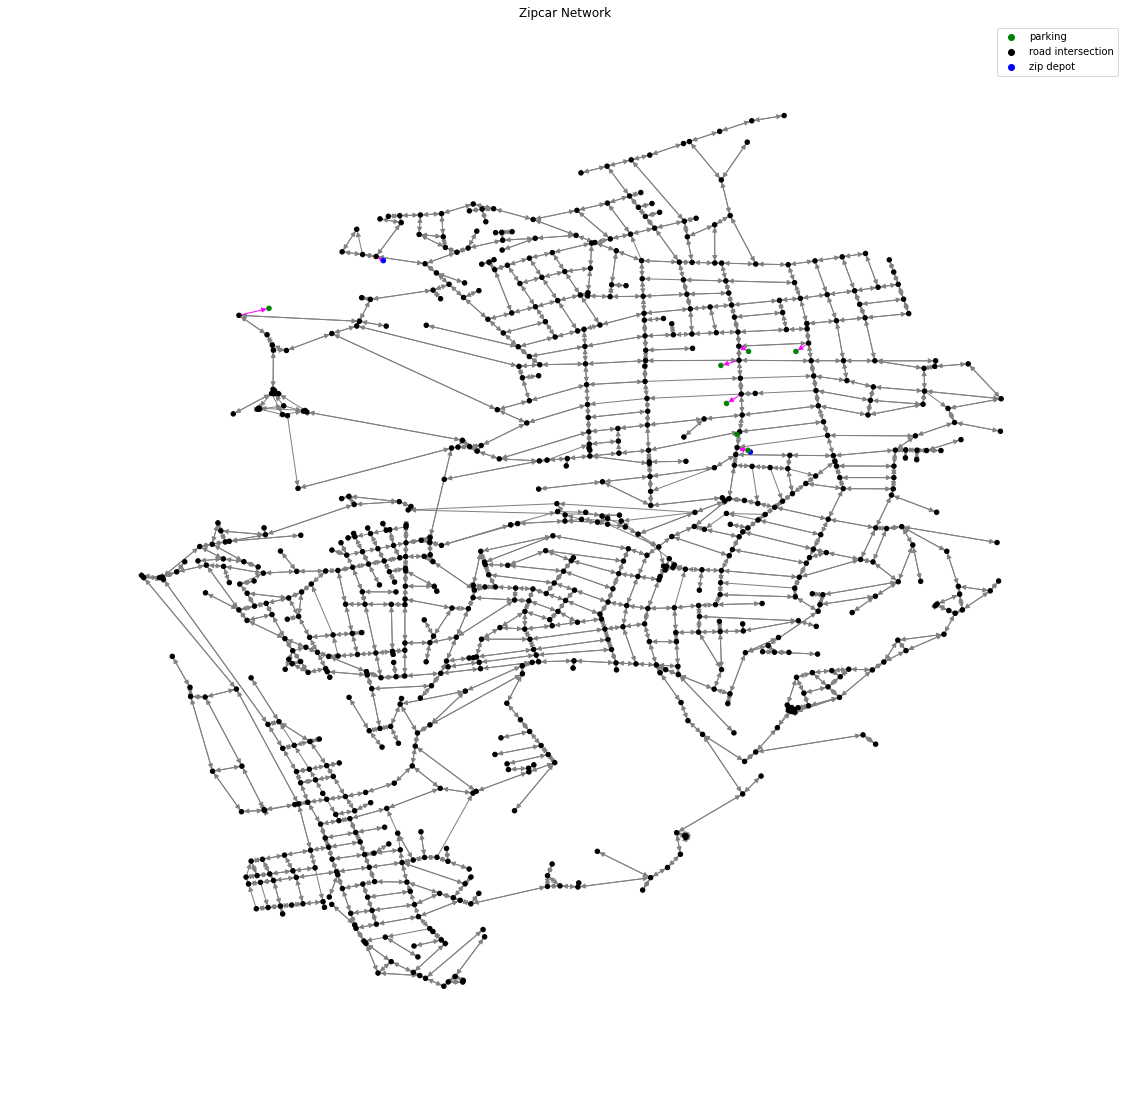

In [100]:
node_color = ['blue' if n.startswith('zd') else 'green' if n.startswith('k') else 'black' for n in G_z.nodes]
edge_color = ['magenta' if (e[0].startswith('zd') or e[1].startswith('k')) else 'gray' for e in G_z.edges]
ax = draw_graph(G_z, node_color, {'road intersection':'black', 'zip depot':'blue', 'parking':'green'}, edge_color)
ax.set_title('Zipcar Network')

## Reduce the size of the PT network
Find the bounding box of the pgh_study_area polygon. Extend this bounding box by 0.5 miles. Then clip the PT network by this extended bounding box

In [101]:
#G_pt.nodes
df = pd.DataFrame.from_dict(dict(G_pt.nodes), orient="index").reset_index()
#gdf_pt = gpd.GeoDataFrame(data=df, geometry=df.pos)
df[['x','y']] = pd.DataFrame(df.pos.tolist())
gdf_ptnodes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y))
gdf_ptnodes.head(3)

,index,x,y,pos,nwk_type,route_id,direction_id,stop_id,geometry
0,ps4875,-79.982614,40.417694,"(-79.982614, 40.417694)",pt,NaN,NaN,NaN,POINT (-79.98261 40.41769)
1,ps4876,-79.984507,40.417637,"(-79.984507, 40.417637)",pt,NaN,NaN,NaN,POINT (-79.98451 40.41764)
2,ps4877,-79.986232,40.417582,"(-79.986232, 40.417582)",pt,NaN,NaN,NaN,POINT (-79.98623 40.41758)


<AxesSubplot:>

<AxesSubplot:>

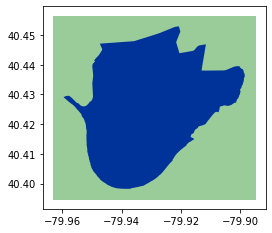

In [102]:

bbox_nhoods = pgh_study_area['geometry'].bounds.T.to_dict()[0]  # bounding box of neighborhood polygon layer
bbox_df = pgh_study_area['geometry'].bounds
bbox_df['newminx'] = bbox_df['minx'] - 1/69 * 0.25  # 1 degree/69 mile
bbox_df['newmaxx'] = bbox_df['maxx'] + 1/69 * 0.25
bbox_df['newminy'] = bbox_df['miny'] - 1/69 * 0.25 
bbox_df['newmaxy'] = bbox_df['maxy'] + 1/69 * 0.25
pt1 = shapely.geometry.Point(bbox_df.newminx, bbox_df.newminy)
pt2 = shapely.geometry.Point(bbox_df.newminx, bbox_df.newmaxy)
pt3 = shapely.geometry.Point(bbox_df.newmaxx, bbox_df.newmaxy)
pt4 = shapely.geometry.Point(bbox_df.newmaxx, bbox_df.newminy)
box = shapely.geometry.Polygon((pt1,pt2,pt3,pt4))
poly = gpd.GeoDataFrame(gpd.GeoSeries(box), columns=['geometry'])

fig,ax = plt.subplots(figsize=(4,4))
pgh_study_area.plot(ax=ax, color='blue')
poly.plot(ax=ax, color='green', alpha=.4)

pt_nodes_clip = gpd.clip(gdf_ptnodes, poly)

In [103]:
pt_nodes_clip.head(3)

,index,x,y,pos,nwk_type,route_id,direction_id,stop_id,geometry
5523,ps12148,-79.938132,40.400208,"(-79.938132, 40.400208)",pt,NaN,NaN,NaN,POINT (-79.93813 40.40021)
11027,rt12148_56_0_27,-79.938132,40.400208,"(-79.938132, 40.400208)",rt,56,0.0,12148,POINT (-79.93813 40.40021)
5528,ps12160,-79.937948,40.400252,"(-79.937948, 40.400252)",pt,NaN,NaN,NaN,POINT (-79.93795 40.40025)


In [104]:
G_pt_clip = dfs_to_nx(pt_nodes_clip, 'index', 'y','x')
df_pt_edges = nx.to_pandas_edgelist(G_pt)
# only keep edges that are within the buffered bounding box
df_edges_keep = df_pt_edges.loc[(df_pt_edges['source'].isin(pt_nodes_clip['index'].tolist())) & (df_pt_edges['target'].isin(pt_nodes_clip['index'].tolist()))]
len(df_edges_keep)
df_edges_keep.head(3)
len(df_pt_edges)

4317

,source,target,interval2_avg_TT_min,interval11_reliability,interval9_avg_TT_min,interval4_risk,interval1_price,interval4_price,interval4_avg_TT_min,interval8_risk,...,interval7_reliability,interval5_price,interval11_price,interval11_risk,interval9_risk,interval3_price,interval0_risk,interval12_risk,mode_type,interval7_price
73,ps5126,rt5126_P3_1_11,7.5,11.25,7.5,0.0,2.75,2.75,7.5,0.0,...,11.25,2.75,2.75,0.0,0.0,2.75,0.0,0.0,board,2.75
74,ps5127,rt5127_75_1_62,10.1,15.15,10.1,0.0,2.75,2.75,10.1,0.0,...,15.15,2.75,2.75,0.0,0.0,2.75,0.0,0.0,board,2.75
75,ps5127,rt5127_P3_1_12,7.5,11.25,7.5,0.0,2.75,2.75,7.5,0.0,...,11.25,2.75,2.75,0.0,0.0,2.75,0.0,0.0,board,2.75


33165

In [105]:
df_pt_edge_copy = df_edges_keep.copy()
df_pt_edge_copy.drop(columns = ['source','target'], axis=1, inplace=True)
attr_dict = df_pt_edge_copy.to_dict('index').values()
wtd_edges = dict(zip(pd.MultiIndex.from_frame(df_edges_keep[['source','target']]), attr_dict))
G_pt_clip.add_edges_from(list(wtd_edges.keys()))
nx.set_edge_attributes(G_pt_clip, wtd_edges)

In [106]:
len(G_pt_clip.nodes)
len(G_pt.nodes)

2149

17960

In [107]:
#G_pt_clip.edges[('ps5125', 'rt5125_P1_0_6')]

# Build the supernetwork

In [108]:
# this dict defines which graphs correspond to each mode type 
all_graphs_dict = {'bs':G_bs_pre, 'pt':G_pt_clip, 't':G_tnc, 'pv':G_pv, 'pb':G_pb, 'sc':G_sc, 'z':G_z}

# this dict defines the node names corresponding to each mode type 
all_modes_nodes = {'bs':['bs'], 'pt':['ps','rt'], 't':['t'], 'sc':['sc'], 
                   'pv':['pv','k'], 'pb':['pb'], 'z':['zd','z','kz']}

In [109]:
# define which nodes are fixed and which come from flexible networks 
all_fix_pre = ['bs','ps','k', 'zd', 'kz']  # prefix for fixed nodes
all_flex_pre = ['t', 'pb', 'pv', 'sc']  # prefix for flexible dropoff nodes

## Choose which networks to include in the supernetwork 

In [110]:
# this list is the parameter that defines which modes to include in the supernetwork
#modes_included = ['bs','sc','pv','z', 't', 'pt']   # omit the personal bike network since we have included pv and tnc
modes_included = ['bs', 'z', 'sc', 't', 'pt', 'pb']   # ['pt', 'pb']
# we remove pv for the case study. assume no access to personal vehicle

# for testing, remember to change:
TNC_wait_time = 7  # [min]

In [111]:
# this dict defines which modes and nodes are included in the supernetwork
modes_nodes_included = {k:v for k,v in all_modes_nodes.items() if k in modes_included}

networks_included = [all_graphs_dict[m] for m in modes_included]  # set([all_graphs_dict[m] for m in modes_included])

# prefixes for fixed nodes in the supernetwork
fix_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_fix_pre]
# prefixes for flex nodes in the supernetwork
flex_pre = [n for nodes in modes_nodes_included.values() for n in nodes if n in all_flex_pre]
print('fixed nodes included = ', fix_pre)
print('flex nodes included = ', flex_pre)

fixed nodes included =  ['bs', 'ps', 'zd', 'kz']
flex nodes included =  ['t', 'sc', 'pb']


## Combine the unimodal networks 

In [112]:
G_u = nx.union_all(networks_included)

In [113]:
# add color for zipcar
def node_color_list(G):
    node_color = []
    for n in G.nodes:
        if n.startswith('ps'):
            node_color.append('blue')
        if n.startswith('rt'):
            node_color.append('dimgray')
        if n.startswith('sc'):
            node_color.append('darkcyan')
        if n.startswith('bs'):
            node_color.append('green')
        if n.startswith('t'):
            node_color.append('red')
        if n.startswith('pv'):
            node_color.append('purple')
        if n.startswith('k'):
            node_color.append('black')    
        if n.startswith('z'):
            if n[1] == 'd':  # zip depot
                node_color.append('saddlebrown')
            else:
                node_color.append('sandybrown')
    return node_color

In [114]:
node_cmap = {'phsyical stop':'blue', 'route node':'dimgray', 'scooter':'darkcyan', 'bikeshare':'green',
             'tnc':'red', 'personal vehicle':'purple', 'parking':'black', 'zipcar depot':'saddlebrown',
             'zipcar nwk node':'sandybrown'}
# node_color = node_color_list(G_u)
# ax = draw_graph(G_u, node_color, node_cmap, 'silver')
# ax.set_title('Supernetwork (selected networks superimposed)', fontsize=16)
# # as expected, the networks overlap

In [115]:
# Let's adjust the supernetwork to see if it still looks right

In [116]:
# input: graph and jitter parameter (how much to adjust the x and y coordinates)
# output: adjusted graph with jittered coordinates
# this function is only for visualization purposes. the original coordinates should remain unchanged
def jitter_nodes(G, jitter_param):
    #G_adj = G.copy()
    j = jitter_param
    #print(G.nodes) #[node]['pos'])
    # adjust the nodes positions in the copy 
    for node in G.nodes.keys():
        adj_x = G.nodes[node]['pos'][0] + jitter_param
        #print(adj_x)
        adj_y = G.nodes[node]['pos'][1] + jitter_param
        #print(adj_y)
        nx.set_node_attributes(G, {node: {'pos':(adj_x, adj_y)}})
    return G

In [117]:
#G_adj.nodes['pv104198595']

In [118]:
#modes_included = ['t', 'bs', 'pt', 'sc', 'pv', 'z']

In [119]:
# problem is that tnc, pb, and pv intersections overlap. 
# define and adjusted graph for drawing purposes; not the real graph in physical world

# the TNC graph is the reference graph for drawing since it is the basic road network; # it will remain in its original position 
adjusted_mode_dict = {}   #{'t': G_tnc}
  
# adjust the graphs in the supernetwork using the jitter function
# this is strictly for plotting
for j, m in enumerate(modes_included):  
    #if m != 't':  # tnc graph is the "base" road network so it will not be adjusted
    G_adj = all_graphs_dict[m].copy()
    jitter_nodes(G_adj, jitter_param=(j/100)*2)  # first graph (tnc) will not be adjusted, which is appropriate since it's the basemap
    adjusted_mode_dict[m] = G_adj

In [120]:
G_u_adj = nx.union_all(G for G in adjusted_mode_dict.values()) 
# node_color = node_color_list(G_u_adj)
# ax = draw_graph(G_u_adj, node_color, node_cmap, 'silver')
# ax.set_title('Supernetwork, where phsyically overlapping networks are offset', fontsize=16)

In [121]:
# Node labels included
# def draw_graph(G, node_color, node_cmap, edge_color):
#     # draw the graph in networkx
#     node_coords = nx.get_node_attributes(G, 'pos')    
#     fig, ax = plt.subplots(figsize=(20,20))
#     nx.draw(G, pos=node_coords, with_labels=True, font_size=12, font_color='black',  font_weight = 'bold',
#             node_size=60, node_color=node_color, edge_color=edge_color, arrowsize=16, ax=ax)
#     # add legend for node color    
#     inv_node_cmap = dict(zip(node_cmap.values(), node_cmap.keys()))
#     for v in set(inv_node_cmap.keys()):
#         ax.scatter([],[], c=v, label=inv_node_cmap[v])
#     ax.legend(loc = 'upper right')
#     return ax

**Save G_u** as pandas df

In [122]:
os.getcwd()
df_G_without_tx = nx.to_pandas_edgelist(G_u)
df_G_without_tx.to_csv('df_G_without_tx.csv', index='False')

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data'

# Transfer Edges

## Step 1. Find great circle distance between all nodes in the graph

In [123]:
nid_map, coord_matrix = get_coord_matrix(G_u)
# coord matrix is np array where row i contains the lat/long pair of node i
# node ID map is of form {id_number: node_name}. also make inverse node ID map of form {node_name: id_number}

inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))  
# separate nid map into fixed and flex
nid_map_fixed = {key:val for key,val in nid_map.items() if mode(val) in fix_pre}  # nid_map for fixed network nodes
nid_map_flex = {key:val for key,val in nid_map.items() if mode(val) in flex_pre}  # nid_map for flex network nodes

In [124]:
mode('kz10') in fix_pre

True

In [125]:
# gcd distance matrix: gcd_dist[i,j] is the great circle distance from node i to node j
gcd_dist = np.empty([len(nid_map), len(nid_map)])  # great circle dist in meters 
for i in range(gcd_dist.shape[0]):
    dist_to_all_nodes = calc_great_circle_dist(coord_matrix[i], coord_matrix)  # calc distance from node i to all other nodes
    gcd_dist[i] = dist_to_all_nodes  # calc_great_circle_dist is a function defined above 

In [126]:
gcd_dist[:3,:3]

array([[   0.        , 1429.80813781, 3081.91970339],
       [1429.80813781,    0.        , 1771.33181757],
       [3081.91970339, 1771.33181757,    0.        ]])

## Step 2. Scooter location observation data

**This data is used to determine the cost of reaching the nearest scooter from some fixed point**

Consider a given time interval. We have historical observations of the last 10 days for this time interval. These observations consist of coordinates. We do not need scooter IDs. As a data structure, we can model the data as a dict of the form {date: list of coordinates for past 10 days}. <br>
Assume a person can transfer to a scooter from every fixed node in the graph (PT, parking, & bikeshare depot). Then, a transfer edge exists from each fixed node to the nearest physical scooter node. The task of determining the cost parameters of the transfer edge can be completed as follows: <br>
1. for each fixed node n <br>
    1. for each historical date d:  <br>
        1. find great circle distance from n to all scooter observations  <br>
        1. choose minimum distance i.e. nearest neighbor  <br>
        1. store in list. at the end of this inner loop, we should have 10 items in the list <br>
    1. find average of min distance list, convert to walk time <br>
    1. find 95th percentile of min distance list, convert to time <br>
    1. in the transfer edge code, assign these cost parameters to the cost of the edge (n, nearest_neighbor_n)<br>

This model has some error because the fixed nodes are connected to the nearest scooter nodes (albeit with calibrated cost parameters for the transfer edges). This leads to potential overestimation of path costs on avg <br>
Ex. A person alights a bus. They walk 500 m to the nearest scooter. In reality, they would hop on scooter network at the node that is nearest to the scooter they just picked up. In this model, they are assumed to hop on the scooter network at the node that is nearest to the bus stop. This simplifying assumption makes it possible to build the supernetwork. 

In [131]:
np.random.seed(50)

In [152]:
# inputs: graph, num of days of historical data, num of time intervals, num of scooter obs per time-interval day lower bound
# and upper bound, lower and upper bound of potential (x,y) coordinate of scooter, node id map, some cost parameters
# output: dict of dicts
def gen_data(G, n_days, n_intervals, n_obs, xlb, xub, ylb, yub, 
             node_id_map_fixed, sc_fixcost, walk_speed, reliability_wts): #, avg_bike_segment_length):
    # generate some fake data

    # initialize the scooter cost dictionary: key is the fixed node, the value is dict of costs (different cost for the different time intervals)
    all_costs = dict([(n, {}) for n in node_id_map_fixed.values()])
    
    # For subsequent visualization purposes
    #fig, axs = plt.subplots(2, 5, sharex = True, sharey = True, figsize=(16,8))
    #plt.suptitle('Example: Scooter observations (red) for time interval 0 shown relative to fixed node bs1038 (blue)')
    # for subsequent plotting purposes 
    #node_coords = np.array([val for key,val in nx.get_node_attributes(G_u, 'pos').items() if key in list(node_id_map_fixed.values())])

    for i in range(n_intervals):  # each time interval 
        obs = {}  # obs is a dict, where the key is the day, the value is an array of coordinates representing different observations
        for j in range(n_days):  # each day
            n_obs = n_obs #np.random.uniform(n_obs_lb,n_obs_ub)  # how many scooter observations for the day-time interval pair
            # generate some random data: data is a coordinate matrix
            # the scooter observations should fit within the bounding box of the neighborhood mask polygon layer
            data = [(round(np.random.uniform(xlb, xub),8), 
                     round(np.random.uniform(ylb, yub),8)) for k in range(int(n_obs))]  
            obs[j] = np.array(data)  

        # find edge cost
        node_cost_dict = {}
        for n in node_id_map_fixed.values():  # for each fixed node 
            all_min_dist = np.empty((1,n_days))  # initialize the min distance matrix, one entry per day
                       
            for d in range(n_days):  # how many days of historical scooter data we have 
                all_dist = calc_great_circle_dist(np.array(G.nodes[n]['pos']), obs[d])  # dist from the fixed node to all observed scooter locations 
                min_dist = np.min(all_dist)  # choose the scooter with min dist. assume a person always walks to nearest scooter
                all_min_dist[0,d] = min_dist # for the given day, the dist from the fixed node to the nearest scooter is min_dist
                
#                 if (i == 0 and n == 'bs1038'):   # testing
#                     print(all_dist)
                # **********************************
                # JUST FOR VISUALIZATION PURPOSES
#                 # for fixed node bs1038 and time interval 0, visualize the scooter location data for each day
#                 if (i == 0 and n == 'bs1037'):
#                     row = d // 5
#                     col = d if d <=4 else (d-5)
#                     for k in range(len(obs[d][:,0])):
#                         axs[row,col].plot([G.nodes[n]['pos'][0], obs[d][k,0]], [G.nodes[n]['pos'][1], obs[d][k,1]], 
#                                  c='grey', ls='--', marker = 'o', mfc='r', zorder=1)
#                     axs[row,col].scatter(x = G.nodes[n]['pos'][0], y = G.nodes[n]['pos'][1], c='b', s = 200, zorder=2)
#                     axs[row,col].set_title('Day ' + str(d))
#                     axs[row,col].text(-79.93, 40.412, 'closest scooter: ' + str(round(min_dist,3)) + ' miles', ha='center')
# #                 # **********************************
            
            mean_min_dist = np.mean(all_min_dist)  # mean distance from node n to any scooter in past "n_days" days
            p95 = np.percentile(all_min_dist, 95)  # 95th percentile distance from node n to any scooter in past "n_days" days
            
            node_cost_dict[n] = {'avg_TT_min': (mean_min_dist/walk_speed/60),
                                 'price': sc_fixcost,
                                 'reliability': p95/walk_speed/60,
                                 'risk_idx': 1,
                                 'risk': 1 * (mean_min_dist/walk_speed/60),
                                 'mode_type':'w',
                                 'discomfort': discomf_weight_sw * (mean_min_dist/walk_speed/60),
                                 'etype': 'transfer'}   # 

            
        for node, cost_dict in node_cost_dict.items():
            all_costs[node].update(cost_dict)

 
    return all_costs

In [133]:
# avg length of a segment in the biking graph (assume similar to walking graph)
#avg_bike_seg_length = np.mean(np.array(list(nx.get_edge_attributes(G_bike, 'length').values())))

In [134]:
num_days_of_data = 30
num_obs = 100
sc_costs = gen_data(G_u, num_days_of_data, num_intervals, num_obs, 
                    bbox_nhoods['minx'], bbox_nhoods['maxx'], bbox_nhoods['miny'], bbox_nhoods['maxy'],
                    nid_map_fixed, scoot_fix_price, walk_speed, rel_weights)

In [135]:
sc_costs['bs1037']
# recall that cost_i for fixed node j is the average distance from node j to the NEAREST scooter for the past 10 days
# i.e. average min distance 
# we can use the example figure above and take the average of all the closest scooter distances. should match cost0

{'avg_TT_min': 3.5216427662693,
 'price': 1,
 'reliability': 6.765877254410239,
 'risk_idx': 1,
 'risk': 3.5216427662693,
 'mode_type': 'w',
 'discomfort': 0.35216427662693,
 'etype': 'transfer'}

## Step 3. Build Transfer Edges

In [136]:
# parameters
#modes = ['bs', 'ps', 't', 'k', 'pb', 'sc', 'z'] # all modes
pmx = [('ps','ps'),('bs','ps'),('ps','bs'),('ps','t'),('t','ps'),('t','bs'),('bs','t'), # permitted mode change
       ('k','ps'),('k','t'),('k','bs'),('ps','pb'),('pb','ps'),('ps','sc'),('sc','ps'),('k','sc'),
       ('bs','sc'), ('sc','bs'), ('ps','zd'), ('bs','zd'), ('t','zd'), ('sc','zd'),
       ('kz','ps'),('kz','t'),('kz','bs'),('kz','sc')]     

In [137]:
# returns walking catchment node for the node of interest
# inputs: nodeID of node interest, matrix of gc distances b/w all nodes, and max walking distance
# output: list of nodeIDs of all nodes within the wcz
def wcz(i, dist_matrix, W):
    catchment = np.where(dist_matrix[i] <= W)[0].tolist()
    if i in catchment:
        catchment.remove(i)  # remove self
    return catchment

In [138]:
# inputs: node of interest, matrix of gcd distances b/w all nodes, travel mode of interest, all nodes in the original graph (id+name)
# output: nodeID of the node in the component network of the travel mode of interest that is nearest to the input node of interest
def nn(i, dist_matrix, travel_mode, node_id_map):
    # subset the node_id_map for the nodes in the component network of the travel mode of interest
    nid_map_travel_mode = [key for key,val in node_id_map.items() if val.startswith(travel_mode)]   # this is a list of IDs
    # subset dist matrix for the nodes in the component network of the travel mode of interest
    dist_subset = dist_matrix[:, nid_map_travel_mode]
    # find the node in the component network of interest that is nearest to the input node of interest
    nn_dist = np.amin(dist_subset[i])
    nn_idx = np.argmin(dist_subset[i])
    # now map back to the original node ID
    original_nn_id = nid_map_travel_mode[nn_idx]
    original_nn_name = node_id_map[original_nn_id]
    return (original_nn_id, original_nn_name, nn_dist)

In [139]:
# issue: we are allowing parking -- personal vehicle transfer
# figure out where that is being added 
flex_pre
meters_in_mile
reliability_weight_active_mode

['t', 'sc', 'pb']

1609

1

In [140]:
# transfer edge parameters
W = 0.5 * meters_in_mile  # max walking distance [0.5 miles * 1609 meters/mile]
# Inconvenience parameters 
inc_time = 0 #5  # min
inc_risk = 0 #1.5  # risk index, make comparable to riding non-bike-lane bus segment
inc_price = 0  # $
# this needs to be more carefully considered. numbers based on personal intuition
inc_cost = b_price*inc_price + b_TT*inc_time + b_risk*inc_risk
risk_idx = 1   # assume walking risk index is 1 on all segments

In [141]:
# Now create transfer edges.

# override base_cost = 1 for testing

etype = 'transfer'
trans_edges = {}

for i in list(nid_map_fixed.keys()):
    attrs = {}
    i_name = nid_map[i]  # map back to node name
    catch = wcz(i, gcd_dist, W)  # catchment zone around i (includes both fixed and flex nodes)
    # build fixed-fixed transfer edge
    for j in catch:
        if j in nid_map_fixed.keys():
            j_name = nid_map[j]  # map back to node name
            if (mode(i_name), mode(j_name)) in pmx:         # if mode switch allowed between i and j
                # build the transfer edge
                edge = (i_name, j_name)
                # find the walking time associated with transfer edge, call it walk_cost
                walk_time = gcd_dist[i,j] / walk_speed / 60  # dist[m] / speed [m/s] / 60 s/min  --> [min]
                wait_time = 0
                # account for a no-cost public transit transfer (actually this creates errors, need to use node-movement cost)
                #fixed_price = -PT_price if (mode(i_name) == 'ps') & (mode(j_name) == 'ps') else 0
                fixed_price = 0
                
                # also add an inconvenience cost; this needs to be more carefully considered. make sufficiently large for now
                # actually we can embed inconvenience cost into "discomfort" attribute
                attr_dict = {'avg_TT_min': walk_time + wait_time,
                             'price': fixed_price,
                             'reliability': walk_time * reliability_weight_active_mode,
                             'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                             'risk': 1 * ( walk_time + wait_time),
                             'discomfort': discomf_weight_sw * walk_time,
                             'type': etype,
                             'mode_type': 'w'}                
                trans_edges[edge] = attr_dict
    
    # find the nearest neighbor in each flex network
    # but first, remove 'pv' nodes to prevent arbitary transfers to the pv network
    # 'pv' nodes are considered flexible for the sake of OD connectors 
    
    flex_pre_tx = flex_pre.copy()
    if 'pv' in flex_pre:
        flex_pre_tx.remove('pv') 
    
    if flex_pre_tx:  # check that list is not NoneType
        for m in flex_pre_tx:    # transfers from fixed-flex or flex-fixed
            if ((mode(i_name), m) in pmx) | ((m, mode(i_name)) in pmx):    # if mode switch allowed between i and m
                nnID, nnName, nnDist = nn(i, gcd_dist, m, nid_map)  # tuple in the form of (node_id, node_name, dist)
                if nnID in catch:   #and (m != 'sc')):
                    k_name = nnName
                    edge_in = (i_name, k_name)                
                    edge_out = (k_name, i_name)
                    walk_time = nnDist / walk_speed / 60  # dist[m] / speed [m/s] / 60 s/min               
                    wait_time = TNC_wait_time if mode(edge_in[1]) == 't' else 0
                    fixed_price = TNC_fix_price if mode(edge_in[1]) == 't' else 0

                    if m != 'sc':   # includes inconvenience cost
                        # the transfer edge cost is constant for all times 
                        
                        # separately check if edge_in / edge_out is allowed
                        if (mode(i_name), mode(k_name)) in pmx:   
                            attr_dict = {'avg_TT_min': walk_time + wait_time,
                                         'price': fixed_price,
                                         'reliability': walk_time * reliability_weight_active_mode,
                                         'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                                         'risk': 1 * ( walk_time + wait_time),
                                         'discomfort': discomf_weight_sw * walk_time,
                                         'type': etype,
                                         'mode_type': 'w'} 
                            trans_edges[edge_in] = attr_dict
                            
                        if (mode(k_name), mode(i_name)) in pmx:  # prevents (tnc-parking) transfers
                            #if mode(k_name) == 't':  # this is a cheap solution, should think of better way if possible
                            # remove wait time 
                            # Hardwiring avg_TT_min: walk_time and price:0 is a cheap solution
                            # The reason I'm doing this is to avoid paying fixed or waiting costs when tranferring TO tnc
                            # need to think of a more elegant way. tbd 
                            attr_dict = {'avg_TT_min': walk_time,
                                         'price': 0,
                                         'reliability': walk_time * reliability_weight_active_mode,
                                         'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                                         'risk': 1 * walk_time,
                                         'discomfort': discomf_weight_sw * walk_time,
                                         'type': etype,
                                         'mode_type': 'w'} 
                            trans_edges[edge_out] = attr_dict  

                    else:  # mode is scooter
                        # when transferring TO scooter, assign costs that were created above according to historical data
                        if (mode(i_name), mode(k_name)) in pmx:
                            scoot_attr_dict = sc_costs[i_name]
                            #attr_dict =  {key: (val + inc_cost) for key, val in attr_dict.items()}  # add inconvenience cost to the cost of walking to scooter
                            scoot_attr_dict['type'] = etype
                            trans_edges[edge_in] = scoot_attr_dict

                        # when transferring FROM scooter, use nearest neighbor distance b/c ride scooter to closest pickup point for next mode
                        if (mode(k_name), mode(i_name)) in pmx:  
                            attr_dict = {'avg_TT_min': walk_time,
                                         'price': fixed_price,
                                         'reliability': walk_time * reliability_weight_active_mode,
                                         'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                                         'risk': 1 * walk_time,
                                         'discomfort': discomf_weight_sw * walk_time,
                                         'type': etype,
                                         'mode_type': 'w'} 
                            trans_edges[edge_out] = attr_dict        

In [ ]:
#trans_edges

In [433]:
d = gcd_dist[inv_nid_map['k11'], inv_nid_map['t104663452']]
d / walk_speed / 60 * b_TT

nnDist

nn(inv_nid_map['k11'], gcd_dist, 't', nid_map)

b_TT * (d / walk_speed / 60 + wait_time) + b_price*fixed_price

0.7802162260127806

KeyError: 'transfer'

In [434]:
# nnID, nnName, nnDist = nn(inv_nid_map['bs1041'], gcd_dist, 't', nid_map)
# walk_time = nnDist / walk_speed / 60
# walk_time


In [435]:
# tt = gcd_dist_all[inv_nid_map['bs1070'], inv_nid_map['ps19999']] / walk_speed / 60
# b_TT * tt + inc_cost
# inc_cost

Initially the transfer edge procedure returned transfers from TNC to parking. This makes sense for the return trip, but not the outbound trip. Thus we modified the tranfer edge code.

In [138]:
# test that the transfers make sense
for edge in trans_edges.keys():
    # find the great circle dist between the nodes
    nid_0 = inv_nid_map[edge[0]]
    nid_1 = inv_nid_map[edge[1]]
    gcd = gcd_dist[nid_0, nid_1]
    if gcd > 0.5 * meters_in_mile:
        print(edge[0], edge[1], gcd)   # no results, which means all transfer are to nodes within WCZ (as expected)
    if (mode(edge[0]), mode(edge[1])) not in pmx:   # no results, as expected
        print(edge) 
         # initially returned transfers from TNC to parking. this makes sense for the return trip, but not the outbound trip
         # thus we will modify the tranfer edge code
    if (mode(edge[0]), mode(edge[1])) == ('k', 'pv'):  # no results, as expected, since can't go from park to pv
        print(edge)

In [265]:
# check: which transfers are in transfer edges
m1m2 = set([(re.sub(r'[^a-zA-Z]', '', k[0]), re.sub(r'[^a-zA-Z]', '', k[1])) for k in trans_edges.keys()])
print('transfers included')
m1m2
# which transfers are we not getting -- should be all PT since right now it is not included 
print('transfers not included')
set(pmx) - m1m2

print('transfers not allowed; should be empty set')
set(m1m2) - set(pmx)  # should be the empty set

transfers included


{('pb', 'ps'), ('ps', 'pb'), ('ps', 'ps')}

transfers not included


{('bs', 'ps'),
 ('bs', 'sc'),
 ('bs', 't'),
 ('bs', 'zd'),
 ('k', 'bs'),
 ('k', 'ps'),
 ('k', 'sc'),
 ('k', 't'),
 ('kz', 'bs'),
 ('kz', 'ps'),
 ('kz', 'sc'),
 ('kz', 't'),
 ('ps', 'bs'),
 ('ps', 'sc'),
 ('ps', 't'),
 ('ps', 'zd'),
 ('sc', 'bs'),
 ('sc', 'ps'),
 ('sc', 'zd'),
 ('t', 'bs'),
 ('t', 'ps'),
 ('t', 'zd')}

transfers not allowed; should be empty set


set()

In [142]:
trans_edges_newform = list(zip(list(zip(*trans_edges.keys()))[0], list(zip(*trans_edges.keys()))[1], trans_edges.values()))
new_trans_edges = update_td_edges(trans_edges_newform, num_intervals)
# add transfer edges and their attributes
G_u.add_edges_from(new_trans_edges) 

In [141]:
for e0, e1 in trans_edges:
    if e0.startswith('zd'):
        print(e0,e1)

#[('zd3', 't106324250')]

In [446]:
#G_pv.edges[('pv104198595', 'pv104822545')]

In [440]:
# add transfer edges and their attributes
#G_u.add_edges_from(new_trans_edges)       #(list(trans_edges.keys()))  # real graph

#nx.set_edge_attributes(G_u, trans_edges) # attributes

#G_u_adj.add_edges_from(list(trans_edges.keys()))  # adj graph (for drawing purposes)
#nx.set_edge_attributes(G_u_adj, trans_edges)  # attributes 

## Save the network topology as a csv

In [163]:
df_G = nx.to_pandas_edgelist(G_u)
#df_G.columns
price_cols = ['interval'+str(i)+'_price' for i in range(num_intervals)]
TT_cols = ['interval'+str(i)+'_avg_TT_min' for i in range(num_intervals)]
rel_cols = ['interval'+str(i)+'_reliability' for i in range(num_intervals)]
risk_cols = ['interval'+str(i)+'_risk' for i in range(num_intervals)]
cols_keep = (['source','target','mode_type', 'risk_idx', 'discomfort', 'interval0_COST'] 
             + TT_cols + price_cols + rel_cols + risk_cols)
df_G = df_G[cols_keep]

In [307]:
df_G.mode_type.unique()

array(['board', 'w', 'alight', 'pt', 'pb'], dtype=object)

In [308]:
nonactive_mode
b_rel
board_alight + nonactive_mode
active_sw = ['s','w']
active_b = ['bs','pb']

['pv', 'pt', 't', 'z']

0.35983333333333334

['board', 'alight', 'pv', 'pt', 't', 'z']

In [164]:
# add discomfort for active modes
mask_sw = (df_G['mode_type'].isin(active_modes)) & (df_G['discomfort'].isna())
# one interval's TT is representative of all intervals b/c active modes are not td
df_G.loc[mask_sw, 'discomfort'] = df_G.loc[mask_sw, 'interval0_avg_TT_min'] * discomf_weight_sw

mask_b = (df_G['mode_type'].isin(active_modes)) & (df_G['discomfort'].isna())
# one interval's TT is representative of all intervals b/c active modes are not td
df_G.loc[mask_b, 'discomfort'] = df_G.loc[mask_b, 'interval0_avg_TT_min'] * discomf_weight_bike

df_G.loc[df_G['mode_type'].isin(nonactive_mode + board_alight), 'discomfort'] = 0  # for non-active modes

In [165]:
# add total cost as a function of the five other attributes.
# bikeshare is already calculated b/c precomputed. so do this for all other modes
bs_mask = df_G['mode_type'] == 'bs'
for i in range(num_intervals):
    # exception for mode_type == 'bs'
    df_G.loc[~bs_mask,'interval'+str(i)+'_COST'] = (b_TT * df_G.loc[~bs_mask,'interval'+str(i)+'_avg_TT_min'] +
                                                    b_rel * df_G.loc[~bs_mask,'interval'+str(i)+'_reliability'] +
                                                    b_price * df_G.loc[~bs_mask,'interval'+str(i)+'_price'] +
                                                    b_risk * df_G.loc[~bs_mask,'interval'+str(i)+'_risk'] +
                                                    b_disc * df_G.loc[~bs_mask,'discomfort']) 

In [166]:
# bikeshare is precomputed but only for a single cost (interval0_COST). add this cost for intervals 1-num_intervals
# so that the entire table is full
for i in range(1,num_intervals):
    df_G.loc[bs_mask, 'interval'+str(i)+'_COST'] = df_G.loc[bs_mask, 'interval0_COST']

In [167]:
# only keep cost columns
cost_cols = ['interval'+str(i)+'_COST' for i in range(num_intervals)]
cols_keep = ['source','target','mode_type'] + cost_cols
df_G_final = df_G[cols_keep]

In [168]:
modes_included

['bs', 'z', 'sc', 't', 'pt', 'pb']

In [169]:
df_G_final.loc[df_G_final.interval0_COST.isna()]

,source,target,mode_type,interval0_COST,interval1_COST,interval2_COST,interval3_COST,interval4_COST,interval5_COST,interval6_COST,interval7_COST,interval8_COST,interval9_COST,interval10_COST,interval11_COST,interval12_COST


In [315]:
# check that every cell is filled
df_G_final.isna().sum()

source             0
target             0
mode_type          0
interval0_COST     0
interval1_COST     0
interval2_COST     0
interval3_COST     0
interval4_COST     0
interval5_COST     0
interval6_COST     0
interval7_COST     0
interval8_COST     0
interval9_COST     0
interval10_COST    0
interval11_COST    0
interval12_COST    0
dtype: int64

In [170]:
import shutil

In [178]:
df_G.shape

(53976, 70)

In [179]:
filename_1 = 'graph_FINAL_bs_z_sc_t_pt_pb.csv'
filename_2 = 'graph_RAWCOLS_bs_z_sc_t_pt_pb.csv'
df_G_final.to_csv(cwd + '/OutputData/' + filename_1, index=False)
df_G.to_csv(cwd + '/OutputData/' + filename_2, index=False)
# 
# shutil.make_archive(cwd + '/OutputData', 'zip', cwd + '/OutputData')

In [173]:
# We want to add OD cnx on the fly when constructing shortest path...
# but the shortest path calculation occurs in the Ubuntu environment with MAC-POSTS
# thus we will have to copy over some variables from this local machine to the Ubuntu environment:
filename = 'coord_matrix_bs_z_sc_t_pt_pb'
np.savetxt(cwd + '/OutputData/' + filename, coord_matrix)

nid_map_df = pd.DataFrame(nid_map.items(), columns=['nodeID', 'node_name'])

filename = 'nid_map_bs_z_sc_t_pt_pb'
nid_map_df.to_csv(cwd + '/OutputData/' + filename, index=False)

<AxesSubplot:>

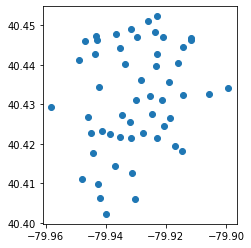

In [237]:
# use block group centroids as test orgs and dests
bg_centroids = pd.read_pickle('bg_centroids.csv')
bg_centroids.plot()
# get all possible OD pairs
indices = list(range(len(bg_centroids)))
idx_pairs = list(itertools.permutations(indices, 2))
# For now, just test with the first 15 pairs
# od_pairs = idx_pairs[::200]
# test = [od_pairs[3]]
# test
# len(od_pairs)

In [319]:
# zip the file before uploading to github
shutil.make_archive(cwd + '/OutputData', 'zip', cwd + '/OutputData')

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Code/OutputData.zip'

## ODs and OD connectors
I think we should add OD connectors on the fly

In [150]:
# this function builds OD connectors on the fly
# input: graphs, coordinates of the org and dst, the nodeID map, list of fixed nodes, list of flex modes, 
# gc dist between all nodes in the graph, max walk distance W, and walk speed parameter 
# output: graphs with OD connector edges added, along with their associated cost 

# note that there are some exceptions: 
# 1) org connects to flex PV;  2) org does not connect to fixed parking;  3) dst does not connect to flex PV
# 4) dst connects to fixed parking;  5) dst does not connect to fixed zip depot
def od_cnx(od_coord_matrix, node_id_map, fixed_node_list, fixed_mode_list, 
           flex_mode_list, gcd_matrix, W, walk_speed, TNC_wait_time, TNC_fixed_price,
           scooter_costs, discomfort_weight, reliability_weights):
    risk_idx = 1  # assume
    od_cnx_edges = {}
    
    inv_node_id_map = {v: k for k, v in node_id_map.items()}
        
    for i_name in ['org','dst']:
        catch = wcz(inv_node_id_map[i_name], gcd_matrix, W)  # find WCZ
        #print(i_name)
        #print('-----')
        # build od connector edge for each FIXED node in the catchment zone 
        for j in catch:
            if j in fixed_node_list:
                j_name = node_id_map[j]  # map back to node name
                #print(j_name, mode(j_name))
                if ((i_name == 'org' and mode(j_name) == 'k') | (i_name == 'org' and mode(j_name) == 'kz') | (i_name == 'dst' and mode(j_name) == 'zd')):   
                    continue  # exceptions 2 and 5
                if i_name == 'org':
                    edge = (i_name, j_name)  # build org connector
                if i_name == 'dst':
                    edge = (j_name, i_name)  # build dst connector                
                
                walk_time = gcd_matrix[inv_node_id_map[i_name], j] / walk_speed / 60  # walking traversal time [min] of edge
                wait_time = 0 
                # note that wait time is not included. this is because we're dealing with fixed modes. only TNC has wait time
                # wait time for PT is embedded in alighting edges
                fixed_price = 0  # for all fixed modes
                attr_dict = {'avg_TT_min': walk_time + wait_time,
                             'price': fixed_price,
                             'reliability': (walk_time + wait_time) * reliability_weights['w'],
                             'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                             'discomfort': discomfort_weight * walk_time,
                             'type': 'od_cnx',
                             'mode_type': 'w'}                
                od_cnx_edges[edge] = attr_dict
                
                #approx_num_walk_segments = gcd_matrix[inv_node_id_map[i_name], j] / avg_bike_segment_length
                #risk_cost = b_risk * risk_idx * approx_num_walk_segments
                #print(walk_cost)

                # add an edge attribute for num_intervals different costs to match the num_intervals time-dependent traversal edge costs
                # but the transfer edge cost is constant for all times 
#                 attr_dict = dict(zip(cost_keys, [walk_cost + risk_cost]*num_intervals))  # holds costs attributes
#                 attr_dict['type'] = 'cnx'    # store edge type
#                 od_cnx_edges[edge] = attr_dict
                
        # some fixed modes do not have a node within the wcz. for these modes, we will instead connect the 
        # org or dst to the nearest neighbor node of for these specific fixed modes. consider this like 
        # relaxing the wcz constraint
        catch_node_names = [node_id_map[c] for c in catch]
        catch_fixed_modes = [re.sub(r'[^a-zA-Z]', '', cname) for cname in catch_node_names]
        
        # which fixed mode does not have a node in the wcz?
        rem_fixed_modes = set(fixed_mode_list) - set(catch_fixed_modes)
        for rm in rem_fixed_modes:
            #print('rm:', rm)
            if ((i_name == 'org' and rm == 'k') | (i_name == 'org' and rm == 'kz') | (i_name == 'dst' and rm == 'zd')):   # exceptions 2/5
                continue
            # nn calc
            nnID, nnName, nnDist = nn(inv_nid_map[i_name], gcd_matrix, rm, node_id_map) 
            r_name = nnName
            cnx_edge_length = nnDist
            walk_time = cnx_edge_length / walk_speed / 60  # [min]
            wait_time = 0
            fixed_price = 0
            
            attr_dict = {'avg_TT_min': walk_time + wait_time,
                         'price': fixed_price,
                         'reliability': (walk_time + wait_time) * reliability_weights['w'],
                         'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                         'discomfort': discomfort_weight * walk_time,
                         'type': 'od_cnx',
                         'mode_type': 'w'}                

            if i_name == 'org':
                edge = (i_name, r_name)  # build org connector
            if i_name == 'dst':
                edge = (r_name, i_name)  # build dst connector
            
            od_cnx_edges[edge] = attr_dict  

        # build od connector edge for the nearest flexible node (relax constraints that needs to be in wcz)
        # also includes an org connector from org to nearest PV node, but does NOT include a dst connector from dst to nearest PV node
        # PV = personal vehicle 
        for m in flex_mode_list:
            if i_name == 'dst' and m == 'pv':  # exception 3
                continue
            nnID, nnName, nnDist = nn(inv_nid_map[i_name], gcd_matrix, m, node_id_map) 
            k_name = nnName
            #print(k_name)
            #if nnID in catch:   *we have decided to relax this constraint*
            
            # do this separately for scooters/TNCs and other flex modes. but have not yet generated TNC data to account for variable pickup wait times
            if (i_name == 'org' and m == 'sc'):
                edge = (i_name, k_name)
                #print(edge)
                sc_cost_dict = scooter_costs[i_name]
                sc_cost_dict['type'] = 'cnx'    # store edge type
                od_cnx_edges[edge] = sc_cost_dict

            else:   
                cnx_edge_length = nnDist
                walk_time = cnx_edge_length / walk_speed / 60  # [min]
                wait_time = TNC_wait_time if (m == 't') & (i_name == 'org') else 0
                fixed_price = TNC_fix_price if (m == 't') & (i_name == 'org') else 0
                # to do: add zip fixed price, maybe 9/4
                
                attr_dict = {'avg_TT_min': walk_time + wait_time,
                             'price': fixed_price,
                             'reliability': (walk_time + wait_time) * reliability_weights['w'],
                             'risk_idx': 1,  # for now, just assume all transfers associated with risk = 1
                             'discomfort': discomfort_weight * walk_time,
                             'type': 'od_cnx',
                             'mode_type': 'w'}                
                
                if i_name == 'org':
                    edge = (i_name, k_name)  # build org connector
                if i_name == 'dst':
                    edge = (k_name, i_name)  # build dst connector
                
                od_cnx_edges[edge] = attr_dict  
    return od_cnx_edges

In [151]:
def dijkstra(G, org, dst, weight):
    weight = weight
    try:
        sp = nx.dijkstra_path(G, org, dst, weight)
        sp_edges = [(sp[i], sp[i+1]) for i in range(len(sp)-1)]
        total_cost = sp_total_cost(G, sp_edges, weight)
        return([sp_edges, total_cost])
    except:
        print('No path to destination')
        return([[],'X'])
    #print(sp_edges)
#     G_sp = G_u_od_adj.copy()
#     G_sp.remove_edges_from(list(G_u_adj.edges))
#     G_sp.add_edges_from(sp_edges)

    # ax = draw_graph(G_sp, node_color, node_cmap, 'magenta')
    # ax.set_title('Shortest Path between Org and Dst \n' + sp_string(sp_edges), fontsize = 14)

<AxesSubplot:>

[(4, 113)]

76

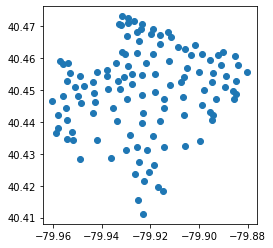

In [164]:
for i in range(0,len(od_pairs),10):
    o,d = od_pairs[i]
    print(o,d)

0 1
16 49
32 97
49 22
65 71
81 119
98 44
114 92


In [163]:
bbox_nhoods['minx'], bbox_nhoods['maxx'], bbox_nhoods['miny'], bbox_nhoods['maxy']

(-79.9595245757169, -79.8985109647237, 40.3982404448334, 40.4529019749748)

Add a parking node approximately at the destination 

In [305]:
#(o,d) = od_pairs[5]

In [154]:
# Add each OD pair and do calcs on the fly
risk_idx = 1  # approx walking risk index per segment

for i in range(0,len(od_pairs),10):
    o,d = od_pairs[i]
    
    # cell copied from above. can be deleted later. used for now for testing purposes just to make sure nid_map is reset
    nid_map = dict(zip(range(len(list(G_u.nodes))), G_u.nodes))
    inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))  

    G_u_od = G_u.copy()  # helpful to do everything on a graph copy 
    #G_u_od_adj = G_u_adj.copy()
    o_coord = (bg_centroids.iloc[o]['geometry'].x, bg_centroids.iloc[o]['geometry'].y)
    d_coord = (bg_centroids.iloc[d]['geometry'].x, bg_centroids.iloc[d]['geometry'].y)
    print(o_coord,d_coord)

    # add the org and dst nodes to the graph along with their positions 
    G_u_od.add_nodes_from([('org', {'pos': o_coord}),   # 'org'+str(i)
                           ('dst', {'pos': d_coord})])

    # build od coord matrix
    od_coords = np.array([list(o_coord),list(d_coord)])

    # create new great circle distance matrix, called gcd_od, where gcd_od[0,j] is the distance from the org
    # to the node with node_id = j and gcd_od[1,j] is the distance from the dst to the node with node_id = j

    # 2 rows because 1 origin and 1 destination 
    nrow, ncol = 2, len(nid_map) + 2  # add 2 to len(nid_map) to account for addition of org node and dst node

    gcd_od = np.empty([nrow, ncol])  
    for j in range(nrow):  # first the org, then the dest
        dist_to_map_nodes = calc_great_circle_dist(od_coords[j], coord_matrix) # dist from OD to modal graph nodes
        dist_to_od = calc_great_circle_dist(od_coords[j], od_coords) # dist from O to O and O to D, then D to O and D to D
        gcd_od[j] = np.hstack((dist_to_map_nodes, dist_to_od)) # horizontally concatenate 

    # now add gcd_dist_od to the original gcd_dist matrix
    # result is gcd_dist_all, which contains the gcd dist b/w all pairs of nodes in the graph, including org and dst
    gcd_dist_all = np.vstack((gcd_dist, gcd_od[:,:len(nid_map)]))
    gcd_dist_all = np.hstack((gcd_dist_all, np.transpose(gcd_od)))

    # add the org and dest to the nid_map and recreate the inverse map
    # also get nid map just for org and dst. useful b/c ...
    nid_map_od = {}

    nid_map[max(nid_map.keys())+1] = 'org'
    nid_map_od[max(nid_map.keys())+1] = 'org'
    nid_map[max(nid_map.keys())+1] = 'dst'
    nid_map_od[max(nid_map.keys())+1] = 'dst'
    inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))

    # cost of transferring to scooter from ORG and to DST from scooter 
    # graph is expectedly blank since it pertains to a fixed bikeshare node
    sc_costs_od = gen_data(G_u_od, num_days_of_data, num_intervals, num_obs_LB, num_obs_UB, 
                           bbox_nhoods['minx'], bbox_nhoods['maxx'], bbox_nhoods['miny'], bbox_nhoods['maxy'],
                           nid_map_od, scoot_fix_price, walk_speed, rel_weights)

    # Build OD connectors
    W_od = 1  # [miles] consider this value more carefully
    # consider it such that the max walking constraint has been largely relaxed


    od_cnx_edges = od_cnx(od_coords, nid_map, list(nid_map_fixed.keys()), fix_pre,
                          flex_pre, gcd_dist_all, W_od * meters_in_mile, walk_speed, TNC_wait_time,
                          TNC_fix_price, sc_costs_od, discomf_weight, rel_weights)    

    od_cnx_edges_newform = list(zip(list(zip(*od_cnx_edges.keys()))[0], list(zip(*od_cnx_edges.keys()))[1], od_cnx_edges.values()))
    new_od_cnx_edges = update_td_edges(od_cnx_edges_newform, num_intervals)

        #print(od_cnx_edges.keys())
        # add od cnx edges and their attributes

    # make networkx graph of od cnx edges b/c it will be easy to merge with graph of traversal/transfer edges
    G_odc = nx.DiGraph()
    G_odc.add_edges_from(new_od_cnx_edges)
    df_Godc = nx.to_pandas_edgelist(G_odc)

    for i in range(num_intervals):
        df_Godc.loc[:,'interval'+str(i)+'_COST'] = (b_TT * df_Godc.loc[:,'interval'+str(i)+'_avg_TT_min'] +
                                                    b_rel * df_Godc.loc[:,'interval'+str(i)+'_reliability'] +
                                                    b_price * df_Godc.loc[:,'interval'+str(i)+'_price'] +
                                                    b_disc * df_Godc.loc[:,'discomfort'] +
                                                    b_risk * df_Godc.loc[:,'risk_idx']) 
    df_Godc = df_Godc[cols_keep]

    # one final network topology graph
    df_graph_final_od = pd.concat([df_G_final, df_Godc], ignore_index=True)

    # convert back to networkx graph and run shortest path
    # this is a process we will do in MAC-POSTS. for now we are just doing it here as prelim testing to find "good" ODs
    G_final = nx.from_pandas_edgelist(df_graph_final_od, 'source', 'target', edge_attr=True, create_using = nx.DiGraph())
    
    path = nx.shortest_path(G_final, 'org', 'dst', 'interval0_COST')
    print(path)
    print('-----')
    path = nx.shortest_path(G_final, 'org', 'dst', 'interval6_COST')
    print(path)

    
#     G_u_od.add_edges_from(list(od_cnx_edges.keys()))  # real graph
#     nx.set_edge_attributes(G_u_od, od_cnx_edges) # attributes

#     # add org-dst edge directly, to account for an OD pair that is walkable 
    
#     OD_dist = gcd_dist_all[inv_nid_map['org'], inv_nid_map['dst']]
    
# #     G_u_od.add_edges_from([('org','dst'), ('dst','org')])
# #     od_walk_cost = b_TT * (OD_dist / walk_speed / 60)  # [min]
# #     risk_cost = b_risk * risk_idx * (OD_dist / avg_bike_seg_length)
# #     nx.set_edge_attributes(G_u_od, {('org','dst'): dict(zip(cost_keys, [od_walk_cost + risk_cost]*num_intervals))}) 
# #     nx.set_edge_attributes(G_u_od, {('dst','org'): dict(zip(cost_keys, [od_walk_cost + risk_cost]*num_intervals))}) # attributes
    
# #     shortest_path_edges, shortest_path_cost = dijkstra(G_u_od, 'org', 'dst', 'interval0_COST')
# #     print(shortest_path_edges)
# #     print(shortest_path_cost)
#     sp = nx.shortest_path(G_u_od, 'org', 'dst', 'interval0_COST')
#     print(sp)
#     print('********************')
    

(-79.92499869914568, 40.41554014494053) (-79.95396134435774, 40.458577453797844)
['org', 'ps8520', 'ps7121', 'ps1177', 'dst']
-----
['org', 'ps8520', 'ps7121', 'ps1177', 'dst']
(-79.92972969791886, 40.44710149518565) (-79.94362599972864, 40.45255938625932)
['org', 'ps8251', 'dst']
-----
['org', 'ps8251', 'dst']
(-79.90323621081889, 40.46100196667141) (-79.88570873699292, 40.447293123543055)
['org', 'bs49321', 'dst']
-----
['org', 'bs49321', 'dst']
(-79.9296832760302, 40.466941385475764) (-79.92291040721614, 40.41115315574664)
['org', 'ps18143', 'ps7679', 'bs1070', 'dst']
-----
['org', 'ps18143', 'ps7679', 'bs1070', 'dst']


In [321]:
G_final.edges[('org', 'bs1070')]
G_final.edges[('bs1070', 't104602802')]
G_final.edges[('org', 't105188975')]

{'mode_type': 'w',
 'interval0_COST': 38.94743903712888,
 'interval1_COST': 38.94743903712888,
 'interval2_COST': 38.94743903712888,
 'interval3_COST': 38.94743903712888,
 'interval4_COST': 38.94743903712888,
 'interval5_COST': 38.94743903712888,
 'interval6_COST': 38.94743903712888,
 'interval7_COST': 38.94743903712888,
 'interval8_COST': 38.94743903712888,
 'interval9_COST': 38.94743903712888,
 'interval10_COST': 38.94743903712888,
 'interval11_COST': 38.94743903712888,
 'interval12_COST': 38.94743903712888}

{'mode_type': 'w',
 'interval0_COST': 11.832494258835517,
 'interval1_COST': 11.832494258835517,
 'interval2_COST': 11.832494258835517,
 'interval3_COST': 11.832494258835517,
 'interval4_COST': 11.832494258835517,
 'interval5_COST': 11.832494258835517,
 'interval6_COST': 11.832494258835517,
 'interval7_COST': 11.832494258835517,
 'interval8_COST': 11.832494258835517,
 'interval9_COST': 11.832494258835517,
 'interval10_COST': 11.832494258835517,
 'interval11_COST': 11.832494258835517,
 'interval12_COST': 11.832494258835517}

{'mode_type': 'w',
 'interval0_COST': 16.657502576621248,
 'interval1_COST': 16.657502576621248,
 'interval2_COST': 16.657502576621248,
 'interval3_COST': 16.657502576621248,
 'interval4_COST': 16.657502576621248,
 'interval5_COST': 16.657502576621248,
 'interval6_COST': 16.657502576621248,
 'interval7_COST': 16.657502576621248,
 'interval8_COST': 16.657502576621248,
 'interval9_COST': 16.657502576621248,
 'interval10_COST': 16.657502576621248,
 'interval11_COST': 16.657502576621248,
 'interval12_COST': 16.657502576621248}

In [304]:
# make networkx graph of od cnx edges b/c it will be easy to merge with graph of traversal/transfer edges
G_odc = nx.DiGraph()
G_odc.add_edges_from(new_od_cnx_edges)
df_Godc = nx.to_pandas_edgelist(G_odc)

for i in range(num_intervals):
    df_Godc.loc[:,'interval'+str(i)+'_COST'] = (b_TT * df_Godc.loc[:,'interval'+str(i)+'_avg_TT_min'] +
                                                b_rel * df_Godc.loc[:,'interval'+str(i)+'_reliability'] +
                                                b_price * df_Godc.loc[:,'interval'+str(i)+'_price'] +
                                                b_disc * df_Godc.loc[:,'discomfort'] +
                                                b_risk * df_Godc.loc[:,'risk_idx']) 
df_Godc = df_Godc[cols_keep]

# one final network topology graph
df_graph_final_od = pd.concat([df_G_final, df_Godc], ignore_index=True)

# convert back to networkx graph and run shortest path
# this is a process we will do in MAC-POSTS. for now we are just doing it here as prelim testing to find "good" ODs
G_final = nx.from_pandas_edgelist(df_graph_final_od, 'source', 'target', edge_attr=True, create_using = nx.DiGraph())
path = nx.shortest_path(G_final, 'org', 'dst', 'interval0_COST')
path

In [330]:
# some testing

gcd_dist_all[inv_nid_map['org'], inv_nid_map['bs1032']]
gcd_dist_all[inv_nid_map['bs1032'], inv_nid_map['zd8']]
gcd_dist_all[inv_nid_map['org'], inv_nid_map['zd8']]
#G_u_od.edges[('org','bs1032')]

2274.755212209381

458.7747995824031

1847.7290282638612

In [320]:
G_u_od.edges['bs1039','bs1044']

{'interval0_COST': 13.198387589705412,
 'interval1_COST': 13.198387589705412,
 'interval2_COST': 13.198387589705412,
 'interval3_COST': 13.198387589705412,
 'interval4_COST': 13.198387589705412,
 'interval5_COST': 13.198387589705412,
 'interval6_COST': 13.198387589705412,
 'interval7_COST': 13.198387589705412,
 'interval8_COST': 13.198387589705412,
 'interval9_COST': 13.198387589705412,
 'interval10_COST': 13.198387589705412,
 'interval11_COST': 13.198387589705412,
 'interval12_COST': 13.198387589705412,
 'type': 'traversal'}

In [334]:
#od_cnx_edges
path = nx.shortest_path(G_u_od, 'org', 'zd3', 'interval0_COST')
total_cost = 0
for i, n in enumerate(path[:-1]):
    total_cost += G_u_od.edges[path[i],path[i+1]]['interval0_COST']
print(total_cost)

47.47187432271767


In [ ]:
df_headway.loc[(df_headway.route_id == '61D') & (df_headway.direction_id == 1)]

### Build an OD connector edge directly from O-D and D-O
This will capture OD pairs where walking the full way is the least cost option

### Draw the graphs including transfer edges

In [ ]:
# edge_cmap = ['silver' if edge_type == 'traversal' else 'gold' for edge, edge_type in nx.get_edge_attributes(G_u_adj,'type').items()]
# node_color = node_color_list(G_u_adj)
# ax = draw_graph(G_u_adj, node_color, node_cmap, edge_cmap)
# ax.set_title('Supernetwork, where phsyically overlapping networks are offset, with transfer edges', fontsize=16)

## Shortest Path

### Single Shortest Path Example

In [ ]:
# # select random ODs for testing
# org = nid_map[floor(np.random.uniform(0, len(G_u.nodes)))]
# while True:
#     dst = nid_map[floor(np.random.uniform(0, len(G_u.nodes)))]
#     if mode(dst) != 'pv':  # right now there is no way to get back to PV network, so generate another destination for testing
#         break
# print(org,dst)

# interesting org/dst: rt8019/ps7787
weight = 'cost2'
sp = nx.dijkstra_path(G_u_od, "org", "dst", weight)
sp_edges = [(sp[i], sp[i+1]) for i in range(len(sp)-1)] 
#print(sp_edges)
G_sp = G_u_od_adj.copy()
G_sp.remove_edges_from(list(G_u_adj.edges))
G_sp.add_edges_from(sp_edges)

print(sp_edges)
# ax = draw_graph(G_sp, node_color, node_cmap, 'magenta')
# ax.set_title('Shortest Path between Org and Dst \n' + sp_string(sp_edges), fontsize = 14)
sp_total_cost(G_u_od, sp_edges, weight)

## Network Topology

Make a network topology dataframe with three columns: link_ID, from_node, to_node
Then make a dataframe that stores link costs. It will be keyed by the link_ID

First: From what I can tell, Qiling's code requires that node IDs are of datatype 'int'. Therefore, I will create a mapping from the string node IDs that I have (which specify which unimodal network the node comes from) to an anonymous int node ID

In [363]:
int_str_nidmap = dict(zip(range(len(G_u_od.nodes)), list(G_u_od.nodes)))
str_int_nidmap = dict(zip(int_str_nidmap.values(), int_str_nidmap.keys()))
# make linkID map
linkID_map = dict(zip(list(G_u_od.edges), range(len(list(G_u_od.edges)))))
#inv_linkID_map = dict(zip(linkID_map.values(),linkID_map.keys()))

In [341]:
# intialize dataframe
df_topology = pd.DataFrame(columns=['linkID','FromNodeId','ToNodeId'])

,linkID,FromNodeId,ToNodeId


0

In [348]:
# fill the network topology df 
for e in G_u_od.edges:  
    row = [linkID_map[e], str_int_nidmap[e[0]], str_int_nidmap[e[1]]]
    df_topology.loc[len(df_topology.index)] = row

In [356]:
cols_keep = ['source','target'] + ['interval'+str(i)+'_COST' for i in range(10)]

In [364]:
df_edges = nx.to_pandas_edgelist(G_u_od)[cols_keep]
# replace 'source' and 'target' with single linkID key
df_edges['linkID'] = df_edges.apply(lambda row: linkID_map[row['source'], row['target']], axis=1)
df_edges = df_edges[['linkID'] + cols_keep].drop(columns=['source','target'])
df_edges.head()

,linkID,interval0_COST,interval1_COST,interval2_COST,interval3_COST,interval4_COST,interval5_COST,interval6_COST,interval7_COST,interval8_COST,interval9_COST
0,0,31.832286,31.832286,31.832286,31.832286,31.832286,31.832286,31.832286,31.832286,31.832286,31.832286
1,1,18.781142,18.781142,18.781142,18.781142,18.781142,18.781142,18.781142,18.781142,18.781142,18.781142
2,2,25.910841,25.910841,25.910841,25.910841,25.910841,25.910841,25.910841,25.910841,25.910841,25.910841
3,3,25.230564,25.230564,25.230564,25.230564,25.230564,25.230564,25.230564,25.230564,25.230564,25.230564
4,4,28.125370,28.125370,28.125370,28.125370,28.125370,28.125370,28.125370,28.125370,28.125370,28.125370


In [367]:
# write the topology and link costs dataframes to csv
os.getcwd()
df_topology.to_csv('df_topology.csv')
df_edges.to_csv('df_linkcosts.csv')

'/Users/lindsaygraff/Documents/Multimodal Transit Research/Data'

**TO DO:** <br>
1. **COMPLETE** Consolidate bikeshare graph by precomputation
    1. **COMPLETE** Dependency: Add FIFO random edge cost function, then run shortest path
1. **COMPLETE** Add public tranit unimodal graph
1. **COMPLETE** Add scooter unimodal graph
1. **COMPLETE** Construct supernetwork
1. **COMPLETE** Visualize plain supernetwork as well as offset supernetwork (where individual network nodes are slightly offset)
1. **COMPLETE** Add random time-dependent edge costs (first-in-first-out random edge cost function)
1. **COMPLETE** Generate fake historical scooter location data
1. **COMPLETE** Once all unimodal networks are included, add transfer edges
1. **COMPLETE** Add OD connector edges
1. **COMPLETE** Draw an "edge-less" graph i.e. G_u_adj but only nodes. Then superimpose the shortest path edges
1. **COMPLETE** Run single shortest path
1. Run time-depdendent shortest path
1. Right now, it is not possible to transfer from TNC to scooter. We can make this possible by adding a transfer edge from every node in the TNC network to its nearest neighbor in the scooter network, and assign costs using the historical data procedure that was used for fixed nodes. Decide if this makes sense
1. **COMPLETE** Create df that consists of network topology i.e. edgeID, fromNodeID, toNodeID
1. **COMPLETE** Something is missing in the PT network. Right now there is a single route edge that may represent many routes, say 61A, 61B, 61C, 61D. Moreover, there are no transfer edges between routes.
    1. Solution: for each physical stop, create as many route nodes as there are route lines
1. Add node-movement costs
1. Incorporate multiple OD pairs